# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Final Exam: COVID-19 Modeling

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



### INSTRUCTIONS

- This final exam is to be completed indivudally.  Do not consult with your peers when working on it (you can aks the teaching staff for clarification questions, including private messages on Ed).
- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

**Note: for all problems, it is up to you to decide how to transform the data (standardization, log transformations, etc.).  Be sure you use and interpret theses transformations approporiately.**

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

# You are free to use any functions/methods within these packages (BS4, ELI5, and LIME are fine too)
# if you would like to use any other, please contact the teaching staff 

# adding some additional imports to simplify syntax
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import power_transform

from sklearn.tree import DecisionTreeRegressor

from sklearn.utils import resample

from statsmodels.api import OLS

import warnings

In [2]:
warnings.filterwarnings("ignore")

<hr style="height:2pt">

# Analyzing the recent spread of COVID-19 

![](fig/vaccine.jpeg)

You are tasked with using the COVID case and vaccination data across counties presented by the CDC to analyze the recent surge in COVID infections and the association with (amonth other predictors).  You are also tasked with building prediction models to forecast how the disease spread will change based on data from the previous week (and  demographic and other measures.

The exam broken into 4 problems:
- Problem 1: Data Wrangling and Explorations
- Problem 2: Interpretive Linear Regression Modeling
- Problem 3: Prediction Modeling
- Problem 4: Further Analysis

You are provided with four raw data files, and a 5th cleaned file is provided to be used for all EDA and modeling tasks.

The variables included in each of the four raw data sets are:

For 'covid_cases_county.csv' (note: counties show up many times in this dataset: once for each data they report the number of cases):
- `date`: the date of the measurement, taken weekly
- `county`: county name
- `state`: the state in which the county lies
- `fips`: the unique Federal Information Processing System (FIPS) codes for the county
- `cases`: the cumulative number of confirmed positive cases up to and including that date
- `deaths`: the cumulative number of confirmed COVID-related deaths up to and including that date


For 'vaccines_county.csv' (note: counties show up many times in this dataset: once for each data they report the number of cases):
- `date`: the date of the measurement, taken weekly
- `fips`: the unique FIPS code for the county
- `fully`: the percent of residents that are fully vaccinated in the county on that date
- `dose1`: the percent of residents that have received at least one vaccine dose in the county on that date.

For 'masks_county.csv' (note: this is based on a survey conducted by the New York Times in summer of 2020):
- `fips`: the unique FIPS code for the county
- `never`: the percent of respondents that report they never wore masks in public
- `rarely`: the percent of respondents that report they rarely wore masks in public
- `sometimes`: the percent of respondents that report they sometimes wore masks in public	
- `frequently`: the percent of respondents that report they frequently wore masks in public	
- `always`: the percent of respondents that report they always wore masks in public

For 'demographics_county.csv' (note: these are various measures taken from 2010 to 2020):
- `fips`: the unique FIPS code for the county
- `population`: total number of residents in the country	
- `hispanic`: the percentage of residents that self-identify as hispanic
- `minority`: the percentage of residents that self-identify as a minority group (non-white)
- `female`: the percentage of residents that self-identify as female
- `unemployed`: the percentage of residents that are unemployed
- `income`: the median household income, in thousnads of dollards
- `nodegree`: the percentage of residents that report not having graduated high school
- `bachelor`: the percentage of residents that report having a college degree
- `inactivity`: the percentage of residents that get less than 1 hour of vigorous exercise a week
- `obesity`: the percentage of residents that are considered obese based on BMI
- `density`: the population density (residents per square mile)
- `votergap20`: Biden voting percentage minus Trump voting percentage in the 2020 election
- `votergap16`: Clinton voting percentage minus Trump voting percentage in the 2016 election


### Data Sources
- Vaccinations [here](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh).
- Cases [here](https://github.com/nytimes/covid-19-data).
- Mask Usage [here](https://github.com/nytimes/covid-19-data/tree/master/mask-use).
- Demographics [here](https://www.ers.usda.gov/data-products/county-level-data-sets/) 
- 2020 Election [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ)



## Question 1 [25pts]: Data Wrangling and Explorations </b></div>

**1.1** Load the data sets as follows:
- 'covid_cases_county.csv' as `covid_raw` 
- 'vaccines_county.csv' as `vaccines_raw`
- 'masks_county.csv' as `masks`
- 'demographics_county.csv' as `demo` 

**1.2** Create a subset of the `covid_raw` data frame that only contains the measures for 5 dates: June 27 and July 4, 11, 18 and 25.  Do the same for the `vaccines_raw`.  Call these subsets `covid` and `vaccines`, respectively, and print out their dimensions (aka, shapes).

**1.3** Determine and print the number of counties that are measured for each time period in `covid` and `vaccines` (do not print out the list of counties, just the number/count).  Comment on what this implies for presence of missing data.

**1.4** Process both `covid` and `vaccines` so that each county is represented by a single row in each data frame (rather than having 5 separate rows for each county: 1 for each time period in part 1.2).  Call these new generate Pandas data frames `covid_by_county` and `vaccines_by_county` separately.  Print out the dimensions of each resulting data frame, and view the header of `covid_by_county`.  Note: you should use informative names for the columns in the resulting data frames: for example, `cases_w30` for the cumulative number of cases on July 25 (it's the 30th week of the calendar year).

**Hint**: Splitting based on dates and then using `pd.DataFrame.merge` (source)[https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html] could be helpful for this task using the `fips` code as the keys to join on (you should drop any counties that are not measured in all time periods...the default argument for `how` in `pd.DataFrame.merge` will behave this way).

**1.5** Merge the 4 data fames (`covid_by_county`, `vaccines_by_county`, `masks`, and `demo`) based on `fips` and save the result as `covid_merged` (you should drop any counties that are not measured in all 4 data frames).  Determine and report how many counties were dropped from `demo` in this process, and view the header of `covid_merged`.

**1.6** Use `covid_merged` to calculate the novel case rate (per 1000 residents) for each of the weeks for all of the counties, and save these as 4 new well-named variables in `covid_merged`.  For example, `rate_w30` can mathematically be represented as `1000*(cases_30-cases_29)/population`.  Plot the histogram of the novel case rate in week 29, `rate_w29`, and comment on what you notice.

**1.7** We did the steps above (and some other minimal processing) and saved the results in `covid_clean.csv` for you.  Use this data file to answer some exploratory questions and all future analyses: 

1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?  
2. Treating the counties as separate and equal observations: in what states did the case rate increase the most?  In what states did the case rate decrease the most (or increse the least)?  List the top 5 for each.  Do you notice any patterns in these states?
3. Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).

    a. The political views in the county (as measured by the votergap in the 2020 election).
    
    b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).
    
    c. The population density of the county.
    
    d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.

## Answers

**1.1** Load the data sets as follows:
- 'covid_cases_county.csv' as `covid_raw` 
- 'vaccines_county.csv' as `vaccines_raw`
- 'masks_county.csv' as `masks`
- 'demographics_county.csv' as `demo` 

Print out each of their dimensions (aka, shapes).

In [3]:
# Load data
covid_raw = pd.read_csv('data/covid_cases_county.csv')
vaccines_raw = pd.read_csv('data/vaccines_county.csv')
masks = pd.read_csv('data/masks_county.csv')
demo = pd.read_csv('data/demographics_county.csv')

# print shapes of the datasets
print(covid_raw.shape[1],"total columns in covid_raw, and ",covid_raw.shape[0],"rows")
print(vaccines_raw.shape[1],"total columns in vaccines_raw",vaccines_raw.shape[0],"rows")
print(masks.shape[1],"total columns in vaccines_raw",masks.shape[0],"rows")
print(demo.shape[1],"total columns in demo",demo.shape[0],"rows")

6 total columns in covid_raw, and  97394 rows
4 total columns in vaccines_raw 96720 rows
6 total columns in vaccines_raw 3142 rows
14 total columns in demo 3114 rows


**1.2** Create a subset of the `covid_raw` data frame that only contains the measures for 5 dates: June 27 and July 4, 11, 18 and 25.  Do the same for the `vaccines_raw`.  Call these subsets `covid` and `vaccines`, respectively, and print out their dimensions (aka, shapes).


In [4]:
# take a look at the covid dataset
covid_raw.head()

,date,county,state,fips,cases,deaths
0,2021-01-03,Autauga,Alabama,1001.0,4305,50.0
1,2021-01-03,Baldwin,Alabama,1003.0,14064,169.0
2,2021-01-03,Barbour,Alabama,1005.0,1530,33.0
3,2021-01-03,Bibb,Alabama,1007.0,1882,46.0
4,2021-01-03,Blount,Alabama,1009.0,4746,63.0


In [5]:
# subset the covid dataset to selected dates
covid = covid_raw.loc[
    (covid_raw['date']=='2021-06-27') |
    (covid_raw['date']=='2021-07-04') |
    (covid_raw['date']=='2021-07-11') |
    (covid_raw['date']=='2021-07-18') |
    (covid_raw['date']=='2021-07-25')
    , :]
print(covid.shape[1],"total columns in covid, and ",covid.shape[0],"rows")

6 total columns in covid, and  16227 rows


In [6]:
# take a look at the vaccine dataset
vaccines_raw.head()

,date,fips,fully,dose1
0,2021-07-25,1001,26.0,34.0
1,2021-07-25,1003,31.4,40.5
2,2021-07-25,1005,27.6,34.3
3,2021-07-25,1007,22.5,29.4
4,2021-07-25,1009,19.3,24.2


In [7]:
# subset the vaccinces dataset to selected dates
vaccines = vaccines_raw.loc[
    (vaccines_raw['date']=='2021-06-27') |
    (vaccines_raw['date']=='2021-07-04') |
    (vaccines_raw['date']=='2021-07-11') |
    (vaccines_raw['date']=='2021-07-18') |
    (vaccines_raw['date']=='2021-07-25')
    , :]
print(vaccines.shape[1],"total columns in vaccinces, and ",vaccines.shape[0],"rows")

4 total columns in vaccinces, and  16120 rows


**1.3** Determine and print the number of counties that are measured for each time period in `covid` and `vaccines` (do not print out the list of counties, just the number/count).  Comment on what this implies for presence of missing data.


In [8]:
# count the number of counties per day in the covid dataset
counties_by_day_covid = covid.groupby('date').agg({'county': 'count',})
print("Number of counties per day in covid dataset:")
counties_by_day_covid.head()

Number of counties per day in covid dataset:


,county
date,
2021-06-27,3245
2021-07-04,3245
2021-07-11,3245
2021-07-18,3246
2021-07-25,3246


**Comment:** Not all days have the same number of counties. It seems some days have no data for some counties (i.e. missing data).

In [9]:
# count the number of FIPS per day in the vaccines dataset
counties_by_day_vaccines = vaccines.groupby('date').agg({'fips': 'count',})
print("Number of FIPS per day in vaccines dataset:")
counties_by_day_vaccines.head()

Number of FIPS per day in vaccines dataset:


,fips
date,
2021-06-27,3224
2021-07-04,3224
2021-07-11,3224
2021-07-18,3224
2021-07-25,3224


**Comment:** We can observe missing data. Not all dates have the same number of counties in the covid and vaccinces dataset. We'll need dilligence when merging the two datasets.

**1.4** Process both `covid` and `vaccines` so that each county is represented by a single row in each data frame (rather than having 5 separate rows for each county: 1 for each time period in part 1.2).  Call these new generate Pandas data frames `covid_by_county` and `vaccines_by_county` separately.  Print out the dimensions of each resulting data frame, and view the header of `covid_by_county`.  Note: you should use informative names for the columns in the resulting data frames: for example, `cases_w30` for the cumulative number of cases on July 25 (it's the 30th week of the calendar year).

**Hint**: Splitting based on dates and then using `pd.DataFrame.merge` (source)[https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html] could be helpful for this task using the `fips` code as the keys to join on (you should drop any counties that are not measured in all time periods...the default argument for `how` in `pd.DataFrame.merge` will behave this way).




In [10]:
# turn the long format into a wide format
# reset the index to repivot
covid_by_county = covid.reset_index(level=0)
# 
covid_by_county = covid_by_county.pivot_table(index=['fips'], columns='date',
                    values=['cases', 'deaths'], aggfunc='sum', margins=False)

In [11]:
# reformat the column names to one level
# create a list of the new column names in the right order
new_cols=[('{1} {0}'.format(*tup)) for tup in covid_by_county.columns]

# assign it to the dataframe (assuming you named it pivoted
covid_by_county.columns= new_cols

# resort the index, so you get the columns in the order you specified
covid_by_county = covid_by_county.sort_index(axis='columns')

In [12]:
# rename the columns
covid_by_county = covid_by_county.rename(columns = {'2021-06-27 cases': 'cases_w26', 
                          '2021-07-04 cases': 'cases_w27',
                          '2021-07-11 cases': 'cases_w28',
                          '2021-07-18 cases': 'cases_w29',
                          '2021-07-25 cases': 'cases_w30',
                          '2021-06-27 deaths': 'deaths_w26', 
                          '2021-07-04 deaths': 'deaths_w27',
                          '2021-07-11 deaths': 'deaths_w28',
                          '2021-07-18 deaths': 'deaths_w29',
                          '2021-07-25 deaths': 'deaths_w30',
                          }, inplace = False)

In [13]:
# check out the covid dataset
covid_by_county.head()

,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,deaths_w30
fips,,,,,,,,,,
1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,113.0
1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,325.0
1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,61.0
1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,65.0
1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,139.0


In [14]:
# retain the number of columns for future use
nr_columns_covid_by_county = covid_by_county.shape[1]

In [15]:
# turn the long format into a wide format
# reset the index to repivot
vaccines_by_county = vaccines.reset_index(level=0)
# 
vaccines_by_county = vaccines_by_county.pivot_table(index=['fips'], columns='date',
                    values=['fully', 'dose1'], aggfunc='sum', margins=False)

In [16]:
# reformat the column names to one level
# create a list of the new column names in the right order
new_cols=[('{1} {0}'.format(*tup)) for tup in vaccines_by_county.columns]

# assign it to the dataframe (assuming you named it pivoted
vaccines_by_county.columns= new_cols

# resort the index, so you get the columns in the order you specified
vaccines_by_county = vaccines_by_county.sort_index(axis='columns')

In [17]:
# rename the columns
vaccines_by_county = vaccines_by_county.rename(columns = {
                          '2021-06-27 fully': 'fully_w26', 
                          '2021-07-04 fully': 'fully_w27',
                          '2021-07-11 fully': 'fully_w28',
                          '2021-07-18 fully': 'fully_w29',
                          '2021-07-25 fully': 'fully_w30',
                          '2021-06-27 dose1': 'dose1_w26', 
                          '2021-07-04 dose1': 'dose1_w27',
                          '2021-07-11 dose1': 'dose1_w28',
                          '2021-07-18 dose1': 'dose1_w29',
                          '2021-07-25 dose1': 'dose1_w30',
                          }, inplace = False) 

In [18]:
# merge the data with an inner join to remove counties with missing data
covid_and_vaccines_by_fips = covid_by_county.merge(vaccines_by_county, on=['fips'])

# post merge, split the data back into separate datasets
# this will allow both datasets to have an identical set of fips
covid_by_county = covid_and_vaccines_by_fips.iloc[:,:nr_columns_covid_by_county]
vaccines_by_county = covid_and_vaccines_by_fips.iloc[:,nr_columns_covid_by_county:]

In [19]:
# check out the shape of the wide datasets
print(covid_by_county.shape[1],"total columns in covid_by_county, and ",covid_by_county.shape[0],"rows")
print(vaccines_by_county.shape[1],"total columns in vaccines_by_county",vaccines_by_county.shape[0],"rows")

10 total columns in covid_by_county, and  3214 rows
10 total columns in vaccines_by_county 3214 rows


In [20]:
# inspect the covid data
covid_by_county.head()

,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,deaths_w30
fips,,,,,,,,,,
1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,113.0
1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,325.0
1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,61.0
1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,65.0
1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,139.0


**Comment:** As expected, some records were dropped as part of the merge. There are now 3214 rows, instead of 3218. The rows are identical as an inner join merge dropped records where no matching fips were found.

**1.5** Merge the 4 data fames (`covid_by_county`, `vaccines_by_county`, `masks`, and `demo`) based on `fips` and save the result as `covid_merged` (you should drop any counties that are not measured in all 4 data frames).  Determine and report how many counties were dropped from `demo` in this process, and view the header of `covid_merged`.



In [21]:
# retain the original nr. of rows in demo
demo_fips_cnt = demo.shape[0]

# Merge the datasets
covid_merged = covid_by_county.merge(vaccines_by_county, on=['fips'])
covid_merged = covid_merged.merge(masks, on=['fips'])
covid_merged = covid_merged.merge(demo, on=['fips'])
print("The number of records dropped from demo is:", demo_fips_cnt - covid_merged.shape[0])

The number of records dropped from demo is: 6


In [22]:
covid_merged.head()

,fips,cases_w26,deaths_w26,cases_w27,deaths_w27,cases_w28,deaths_w28,cases_w29,deaths_w29,cases_w30,...,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20,votergap16
0,1001.0,7244,113.0,7262,113.0,7299,113.0,7347,113.0,7419,...,51.475,5.2,54.366,13.8,21.9,28.6,34.1,91.8,-44.418437,-49.479
1,1003.0,21945,314.0,22043,315.0,22267,318.0,22802,323.0,23810,...,51.261,5.5,49.626,11.0,28.6,22.3,27.4,114.6,-53.762343,-57.786
2,1005.0,2344,60.0,2347,60.0,2365,60.0,2394,60.0,2434,...,46.589,8.9,34.971,25.4,13.6,31.8,44.4,31.0,-7.663054,-5.611
3,1007.0,2686,64.0,2693,64.0,2702,65.0,2727,65.0,2801,...,46.110,6.6,39.546,22.1,10.2,33.9,40.3,36.8,-57.727983,-55.544
4,1009.0,6967,139.0,6988,139.0,7023,139.0,7099,139.0,7184,...,50.592,5.4,45.567,21.9,12.3,28.0,34.6,88.9,-80.002175,-81.382


**1.6** Use `covid_merged` to calculate the novel case rate (per 1000 residents) for each of the weeks for all of the counties, and save these as 4 new well-named variables in `covid_merged`.  For example, `rate_w30` can mathematically be represented as `1000*(cases_30-cases_29)/population`.  Plot the histogram of the novel case rate in week 29, July 12-18, `rate_w29`, and comment on what you notice.



In [23]:
# calculate novel case rates
covid_merged['novel_case_rate_w27'] = 1000*(covid_merged['cases_w27'] - 
                                           covid_merged['cases_w26']) / covid_merged['population']
covid_merged['novel_case_rate_w28'] = 1000*(covid_merged['cases_w28'] - 
                                           covid_merged['cases_w27']) / covid_merged['population']
covid_merged['novel_case_rate_w29'] = 1000*(covid_merged['cases_w29'] - 
                                           covid_merged['cases_w28']) / covid_merged['population']
covid_merged['novel_case_rate_w30'] = 1000*(covid_merged['cases_w30'] - 
                                           covid_merged['cases_w29']) / covid_merged['population']

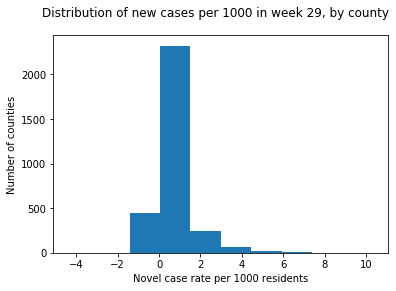

In [24]:
# show histograme for week 29
novel_case_rate_w29_hist = plt.hist(covid_merged['novel_case_rate_w29'])
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.suptitle("Distribution of new cases per 1000 in week 29, by county")
plt.show()

**Comment:** Most counties showed an increase of 1 or 2 cases per thousand in week 29. A few counties had more than 2, going up to an increase of 7 cases per 1000. Close to 500 counties saw a decrease by 1 or w cases, relative to the previous week. The data is not normally distributed, which could cause some issues in later modeling.

**1.7** We did the steps above (and some other minimal processing) and saved the results in `covid_clean.csv` for you.  Use this data file to answer some exploratory questions and all future analyses: 

1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?  
2. Treating the counties as separate and equal observations: in what states did the case rate increase the most?  In what states did the case rate decrease the most (or increse the least)?  List the top 5 for each.  Do you notice any patterns in these states?
3. Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).

    a. The political views in the county (as measured by the votergap in the 2020 election).
    
    b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).
    
    c. The population density of the county.
    
    d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.

In [25]:
# read the cleaned dataset
covid_clean = pd.read_csv('data/covid_clean.csv')

**1. Has the overall average case rate increased from week 28 (July 5-11) to week 29 (July 12-18)?**

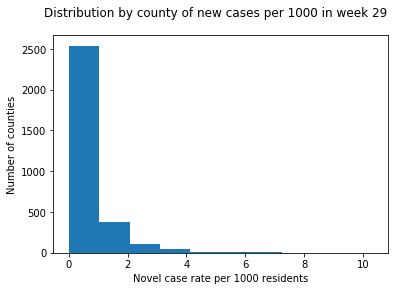

In [26]:
# plot novel cases per 1000 for w29
novel_case_rate_w29_hist = plt.hist(covid_clean['rate_w29']*1000)
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.suptitle("Distribution by county of new cases per 1000 in week 29")
plt.show()

In [27]:
average_covid_increase = covid_clean['rate_w29'].mean()
print("Average covid increase per 1000 in week 29:", average_covid_increase *1000)

Average covid increase per 1000 in week 29: 0.6592153128754568


**Comment:**: The histogram shows that overall rate of covid cases has increased for all counties, on average 0.66 per thousand

**2. Treating the counties as separate and equal observations: in what states did the case rate increase the most? In what states did the case rate decrease the most (or increse the least)? List the top 5 for each. Do you notice any patterns in these states?**

In [28]:
# show the counties with the highest rate increase
covid_clean.sort_values('rate_w29', ascending=False).head()

,fips,date,county,state,cases_w30,deaths_w30,fully_w30,dose1_w30,cases_w26,deaths_w26,...,votergap16,never,rarely,sometimes,frequently,always,rate_w30,rate_w29,rate_w28,rate_w27
385,13053,2021-07-25,Chattahoochee,Georgia,4814,17,99.9,99.9,4487,17,...,-11.055,6.1,7.2,10.8,21.4,54.5,0.001319,0.010346,0.006943,0.004097
2552,48127,2021-07-25,Dimmit,Texas,2890,37,0.0,0.0,2511,37,...,37.178,2.1,5.9,9.7,13.3,69.0,0.014941,0.010131,0.006140,0.007573
149,5129,2021-07-25,Searcy,Arkansas,932,18,27.0,32.3,747,18,...,-63.144,10.0,8.8,12.5,14.9,53.8,0.008434,0.008182,0.003902,0.002769
1560,29213,2021-07-25,Taney,Missouri,7302,106,28.1,34.7,5995,99,...,-59.289,5.3,7.9,21.4,15.5,49.9,0.008663,0.008079,0.006872,0.003602
574,17015,2021-07-25,Carroll,Illinois,2043,38,47.3,54.1,1785,38,...,-27.074,3.0,6.4,12.0,19.0,59.6,0.008572,0.007620,0.000000,0.000190


In [29]:
# show the counties with the lowest rate increase
covid_clean.sort_values('rate_w29', ascending=True).head(5)

,fips,date,county,state,cases_w30,deaths_w30,fully_w30,dose1_w30,cases_w26,deaths_w26,...,votergap16,never,rarely,sometimes,frequently,always,rate_w30,rate_w29,rate_w28,rate_w27
1553,29199,2021-07-25,Scotland,Missouri,307,4,20.0,22.9,306,4,...,-58.943,7.3,11.2,20.9,24.6,36.1,0.000208,0.0,0.000000,0.0
1589,30039,2021-07-25,Granite,Montana,204,2,30.2,33.3,204,2,...,-40.567,11.6,17.0,10.9,18.3,42.2,0.000000,0.0,0.000000,0.0
1597,30055,2021-07-25,McCone,Montana,183,2,14.4,14.7,183,1,...,-66.667,14.2,27.4,17.9,26.7,13.9,0.000000,0.0,0.000000,0.0
1598,30057,2021-07-25,Madison,Montana,802,8,36.4,39.2,796,8,...,-44.597,17.2,11.3,10.5,21.0,40.0,0.000536,0.0,0.000268,0.0
1599,30059,2021-07-25,Meagher,Montana,152,7,41.9,44.1,152,7,...,-55.247,18.8,9.3,12.0,20.3,39.6,0.000000,0.0,0.000000,0.0


**Comment:** At first glance it looks like the northern states had the lowest increase in cases, and the mid-country southern states had the highest increase in cases in week 29.

**Create and interpret separate visuals to display how the country case rate in week 29 relates to each of the following variables. Interpret what you see (be specific to this domain).**

**a. The political views in the county (as measured by the votergap in the 2020 election).**

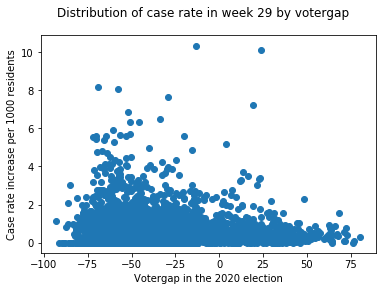

In [30]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(covid_clean['votergap20'],covid_clean['rate_w29']*1000)
plt.xlabel("Votergap in the 2020 election")
plt.ylabel("Case rate increase per 1000 residents")
plt.suptitle("Distribution of case rate in week 29 by votergap")
plt.show()

**Comment:** At lower votergaps (where Trump received the majority of votes), max case rate increases seem to go up an order of magnitude or two higher, as can be observed by the concentration in the scatter plot in the top left quadrant.

**b. The vaccination rate in the county (for week 28) (be sure to throw away the zeros as these represent unreported values).**

In [31]:
# Remove unreported vaccination ratese
covid_clean_nonzero_vac = covid_clean[covid_clean['fully_w28']!=0]
print("Nr of counties with unreported vaccination numbers in week 28:",covid_clean.shape[0]-
                                                                      covid_clean_nonzero_vac.shape[0])

Nr of counties with unreported vaccination numbers in week 28: 273


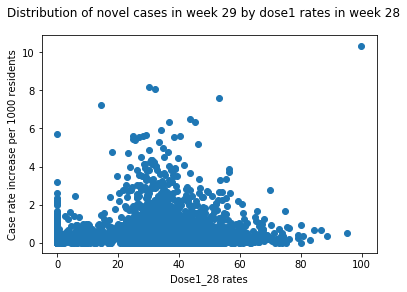

In [32]:
# plot novel cases per 1000 for w29 as a function of vaccination in the previous week
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(covid_clean_nonzero_vac['dose1_w28'],covid_clean_nonzero_vac['rate_w29']*1000)
plt.xlabel("Dose1_28 rates")
plt.ylabel("Case rate increase per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by dose1 rates in week 28")
plt.show()

**Comment:** Without controlling for confounding factors, there does seem to be a pattern between dose1 vaccination rates and case increases. At high (and - surprisingly - low dose1 vaccination rates), case increases seem lower. In the range from 20% to 50% dose1 vaccinated, case increases seem to be highest.
    Note that there seem to be a material amount of 0 dose1. Those, assumingly were not reported.

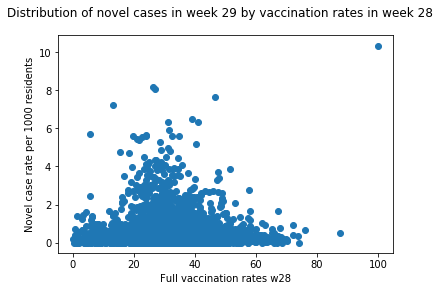

In [33]:
# plot novel cases per 1000 for w29 as a function of vaccination in the previous week
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(covid_clean_nonzero_vac['fully_w28'],covid_clean_nonzero_vac['rate_w29']*1000)
plt.xlabel("Full vaccination rates w28")
plt.ylabel("Novel case rate per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by vaccination rates in week 28")
plt.show()

**Comment:** Without controlling for confounding factors, there does seem to be a pattern between full vaccination rates and case increases. At high (and - surprisingly - low full vaccination rates), case increases seem lower. In the range from 20% to 50% fully vaccinated, case increases seem to be highest.

**c. The population density of the county.**

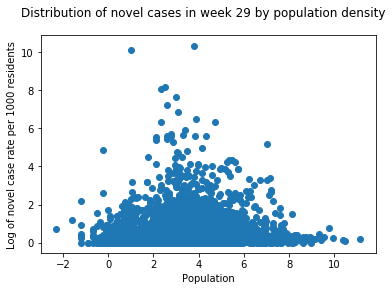

In [34]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
plt.scatter(np.log(covid_clean['density']),covid_clean['rate_w29']*1000)
plt.xlabel("Population")
plt.ylabel("Log of novel case rate per 1000 residents")
plt.suptitle("Distribution of novel cases in week 29 by population density")
plt.show()

**Comment:** Without controlling for confounding factors, it seems where population is between a hundred and a hundred thousand, increases in covid rates are the highest in week 29.

**d. Whether 50% or more of the surveyed residents in the county report that they always wore a mask in public at the time of the survey.**

In [35]:
# subset to mask wearing higher than 50%
covid_clean_mask_adoption_above_50pc = covid_clean[covid_clean['always']>=50]
covid_clean_mask_adoption_below_50pc = covid_clean[covid_clean['always']<50]

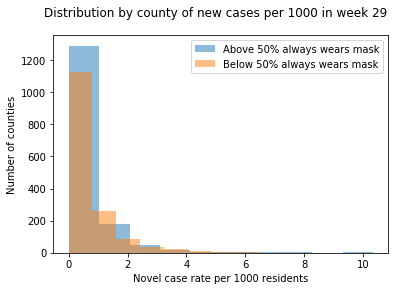

In [36]:
# plot novel cases per 1000 for w29 as a function of votergap
# show the logaritmic view to distribute the scatter more evenly
novel_case_rate_w29_hist_above_50_masked = plt.hist(covid_clean_mask_adoption_above_50pc['rate_w29']*1000, alpha=0.5, label='Above 50% always wears mask')
novel_case_rate_w29_hist_below_50_masked = plt.hist(covid_clean_mask_adoption_below_50pc['rate_w29']*1000, alpha=0.5, label='Below 50% always wears mask')
plt.xlabel("Novel case rate per 1000 residents")
plt.ylabel("Number of counties")
plt.legend()
plt.suptitle("Distribution by county of new cases per 1000 in week 29")
plt.show()

**Comment:** Without controlling for confounding factors, there seems a surprisingly low relationship between mask wearing and case rate increase in a county.

---

## Question 2 [35pts]: Regression modeling 

**2.1** Fit a linear regression model to predict `rate_w29` (which represent the rate of new cases in the week of July 12-18) from `rate_w28` (July 5-11). Report the 95% confidence intervals for the coefficients, and carefully interpret the coefficients (including their statistical significances).  What does this model suggest about whether the rate of COVID infection increased from week 28 to week 29?


**2.2** Fit a linear regression model to predict `rate_w29` from `rate_w28` and `votergap20` along with the interaction between the two.  Interpret the coefficient estimates carefully (no need to mention significances).


**2.3** Create a scatterplot of `rate_w29` vs. `rate_w28`.  Add 3 separate predicted lines from your model in 2.2 to this scatterplot: the predicted line from the model in 2.2 for counties...
    1. where Biden was favored by 50 percentage points.
    2. where Biden and Trump were equal
    3. where Trump was favored by 50 percentage points.
Interpret what you see.


**2.4** Fit a linear regression model to assess the overall association of vaccination rate (`fully_w28`) on `rate_w29`.  Carefully interpret the results (including the statistical significance).  


**2.5** Many counties have the value zero for `fully_w28` which really represents a missing/unreported value for vaccinationr rate.  Comment on the effect of ignoring this issue can have on the intepretations and inferences in the model in 2.4.  What would be a better way of handling this issue?


**2.6** What factors could be confounded (whether measured here or not) with the result seen in the model from 2.3 (list up to 3)?  Fit an appropriate linear model that controls for as many of these factors as possible (for those that are measured in this data set). Interpret the coefficient estimates from this model and compare to the results from 2.4.

**2.7** What major issue could arise if you fit a model to predict `rate_w29` from `rate_w28` and `rate_w27` (or from `fully_w28` and `fully_w27`) in a linear regression model?  Suggest and explain the use of two different approaches to account for this: one approach should be based on modeling and one approach should be based on feature engineering/variable transformations (not PCA). 

**2.8** The test set has a response variable that is `rate_w30`.  How would you use your models to predict `rate_w29` in this section in order to predict `rate_w30` instead?  Explain.  What could go wrong in this modification?

**Hint**: what should be the predictors to predict `rate_w30` instead of `rate_w29`? 


## Answers

**2.1** Fit a linear regression model to predict `rate_w29` (which represent the rate of new cases in the week of July 12-18) from `rate_w28` (July 5-11). Report the 95% confidence intervals for the coefficients, and carefully interpret the coefficients (including their statistical significances).  What does this model suggest about whether the rate of COVID infection increased from week 28 to week 29?


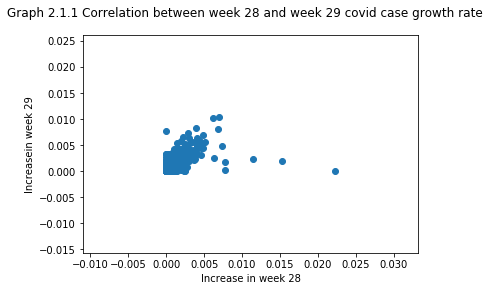

In [37]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Graph 2.1.1 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

**Comment:** Graph 2.1.1 would indicate there is a positive linear relationship between the rate of increase in week 28 and the rate of increase in week 29. This is quite intuive as one would assume a certain level of momentum. The plot, however, also indicates that there are some signicant outliers in week 28 that don't seem to be outliers in week29.

In [38]:
# shape the data for regression with one series
rate_w29 = covid_clean['rate_w29'].to_numpy().reshape(-1,1)
rate_w28 = covid_clean['rate_w28'].to_numpy().reshape(-1,1)

# add intercept
OLS_X = sm.tools.add_constant(rate_w28)

# fit the model on the training data
OLSModel = OLS(rate_w29,OLS_X).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     1938.
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                 18129.
No. Observations:                3108   AIC:                        -3.625e+04
Df Residuals:                    3106   BIC:                        -3.624e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   1.45e-05     24.522      0.000       0.000       0.000
x1             0.6603      0.015     44.021      0.000       0.631       0.690
==============================================================================
Omnibus:                     1992.200   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           914336.075
Skew:                          -1.766   Prob(JB):                         0.00
Kurtosis:                      86.953   Cond. No.                     1.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# grab the coefficients confidence intervals from the model
confidence_intervals = OLSModel.conf_int(alpha=0.05, cols=None)
pvalues = OLSModel.pvalues

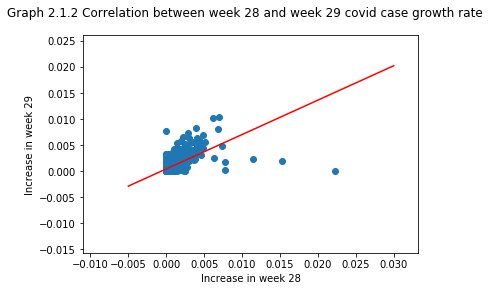

In [40]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increase in week 29")
i=0.0004       # intercept
s=0.6603        # slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
plt.plot(x, s*x + i, c = 'red')    
plt.suptitle("Graph 2.1.2 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

In [41]:
# printing values from the summary table
print("The 95% confidence interval for the intercept is:", confidence_intervals[0][0], "-", confidence_intervals[0][1])
print("The statistical significance (p-value) for the intercept is:", pvalues[0])
print("The 95% confidence interval for the slope is:", confidence_intervals[1][0], "-", confidence_intervals[1][1])
print("The statistical significances (p-value) for the slope is:", pvalues[1])

The 95% confidence interval for the intercept is: 0.00032658901296613653 - 0.00038335564460932316
The statistical significance (p-value) for the intercept is: 1.5512689757340049e-121
The 95% confidence interval for the slope is: 0.6309326693377665 - 0.6897576653275962
The statistical significances (p-value) for the slope is: 0.0


**Comment:** The statistical significance for both coefficients is 0. This means the probability that we would find these coefficients if the null hypothesis were true, is zero. As such, the coefficients are considered statistically significant. 
The intercept coefficient is very close to 0. Most of the effect is therefore between rate_28 and rate_29.
The slope coefficient is estimated at 0.6603: for every increase in rate_28 for a county, we - on average - expect rate_29 rate to increase by 0.6603. As such - as the coefficient is less than one - this suggests the rate of COVID infection DEcreased from week 28 to week 29.
When graphing the relationship however, it seems reasonable to conclude that the slope is underestimated, probably due to outliers on the bottom right. Note also that the R squared is 38.4%, indicating 38.4% of the variance in rate_w29 is explained by rate_28.

**2.2** Fit a linear regression model to predict `rate_w29` from `rate_w28` and `votergap20` along with the interaction between the two.  Interpret the coefficient estimates carefully (no need to mention significances).


In [42]:
# add intercept, taking into account both regressors
covid_clean['rate_w28*votergap20'] = covid_clean['rate_w28']*covid_clean['votergap20']
OLS_x_train = sm.tools.add_constant(covid_clean[['rate_w28','votergap20', 'rate_w28*votergap20']])

# limit the target variable to pickup count for the dataset
y_train = covid_clean['rate_w29']

In [43]:
# fit the model on the training data
OLSModel = OLS(y_train,OLS_x_train).fit()
print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel.summary()

Statmodels results: 
const                  0.000136
rate_w28               1.189928
votergap20            -0.000005
rate_w28*votergap20    0.010237
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rate_w29   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     873.9
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:28:10   Log-Likelihood:                 18327.
No. Observations:                3108   AIC:                        -3.665e+04
Df Residuals:                    3104   BIC:                        -3.662e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0001   1.99e-05      6.819      0.000    9.68e-05       0.000
rate_w28                1.1899      0.030     39.885      0.000       1.131       1.248
votergap20          -4.804e-06   4.18e-07    -11.480      0.000   -5.62e-06   -3.98e-06
rate_w28*votergap20     0.0102      0.001     20.324      0.000       0.009       0.011
==============================================================================
Omnibus:                      982.476   Durbin-Watson:                   1.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189519.319
Skew:                          -0.134   Prob(JB):                         0.00
Kurtosis:                      41.254   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

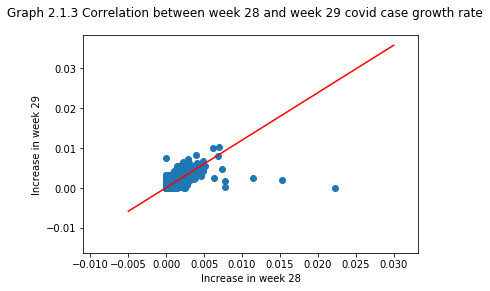

In [44]:
# plot novel cases per 1000 for w29 as a function of w29
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'])
plt.xlabel("Increase in week 28")
plt.ylabel("Increase in week 29")
i=0.0001       # intercept
s=1.1907       # slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
plt.plot(x, s*x + i, c = 'red')    
plt.suptitle("Graph 2.1.3 Correlation between week 28 and week 29 covid case growth rate")
plt.show()

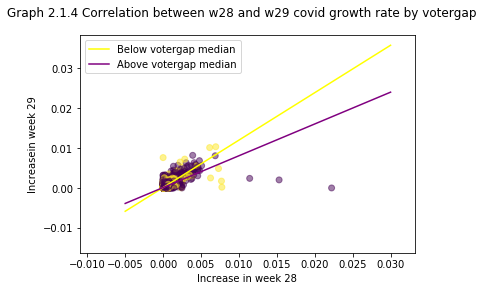

In [45]:
# plot the interaction
votergap20_median = covid_clean.votergap20.median()
covid_clean['gap20_med'] = covid_clean.votergap20 > votergap20_median
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'], c=covid_clean['gap20_med'], alpha = 0.5)
# plot below median votergap slope
x=np.linspace(-0.005,0.03,20)      # from 1 to 10, by 50
i=0.0001       # intercept
s=1.1907       # slope below median
plt.plot(x, s*x + i, c = 'yellow', label='Below votergap median')   
# plot above median votergap slope
s= 1.1907 + 0.0102 * votergap20_median
plt.plot(x, s*x + i, c = 'purple', label='Above votergap median')
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Graph 2.1.4 Correlation between w28 and w29 covid growth rate by votergap")
plt.legend()

In [46]:
# showing all rows and columns when displaying pandas info 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [47]:
# show the outliers
print("Votergap outliers:")
covid_clean.loc[:,['county','votergap20']][covid_clean['rate_w28'] > 0.01]

Votergap outliers:


,county,votergap20
1105,Franklin,-44.362140
1607,Powder River,-71.830986
2639,Loving,-84.848485


**Comment:** 
Coefficient interpretation:
- At 0 rate_w28 and 0 votergap20, we rate_w29 mpg to be 0.0001
- For every 1 unit increase in rate_w28 (the increase in covid cases per 1000, relative to the previous week), rate_w29 increases by 1.1899 (holding votergap20 at 0)
- For every 1 unit increase in rate_w28, rate_w29 changes by 1.1899 + votergap20 * 0.0102 (where votergap20 is not 0)
- For every 1 unit increase in votergap20, rate_w29 changes by -4.804e-06 (holding rate_28 at 0)
- For every 1 unit increase in votergap20, rate_w29 changes by -4.804e-06 + rate_28 * 0.0102 (where rate_28 is not 0)

**Comment:** While the coefficient for votergap is relatively small, there is a material effect when controlling for votergap and the interaction with rate_w28. After controlling for votergap20 (and the interaction), the coefficient for rate_w28 is almost 1.19. This indicates that for every increase in rate_w28, rate_29 increased by 20% more.
After controlling for the confounding factors, the regression graph 2.1.3 also looks more reasonable.
The interaction variable indicates how different the slope for rate_w28 is as voter gap changes. As median votergap20 is negative, for each one change in voter gap, the slope for rate_w28 decreases by 0.01. This is  illustrated in graph 2.1.4 in purple. The graph also demonstrates how the purple line may be pushed down by outliers for counties Franklin, Powder River, and Loving, counties where Trump significantly outperformed Biden. R squared increases from 38.4 to 45.8 by adding votergap20 and the interaction with rate_28.

**2.3** Create a scatterplot of `rate_w29` vs. `rate_w28`.  Add 3 separate predicted lines from your model in 2.2 to this scatterplot: the predicted line from the model in 2.2 for counties...
    1. where Biden was favored by 50 percentage points.
    2. where Biden and Trump were equal
    3. where Trump was favored by 50 percentage points.
Interpret what you see.




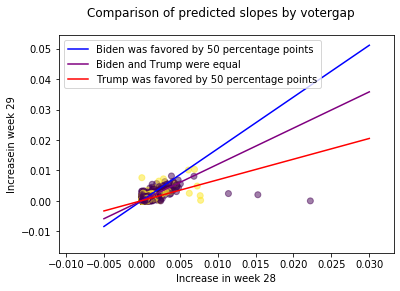

In [48]:
# plot various predicted lines for three votergap scenarios


# We can see the interaction by cutting one of the terms in the interaction along it’s median,
# and then plotting the response variable against the other variable in the interacting pair
votergap20 = covid_clean.votergap20.median()
covid_clean['gap20_med'] = covid_clean.votergap20 > votergap20_median
plt.scatter(covid_clean['rate_w28'],covid_clean['rate_w29'], c=covid_clean['gap20_med'], alpha = 0.5)

# line specs
x=np.linspace(-0.005,0.03,20) 
i=0.0001       # intercept

# plot where Biden was favored by 50 percentage points
votergap20 = 50
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'blue', label='Biden was favored by 50 percentage points')   

# plot where Biden and Trump were equal
votergap20 = 0
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'purple', label='Biden and Trump were equal')

# plot where Trump was favored by 50 percentage points.
votergap20 = -50
s = 1.1899 + 0.0102 * votergap20       # slope as a function of votergap20
plt.plot(x, s*x + i, c = 'red', label='Trump was favored by 50 percentage points')   

# Clean up plot
plt.xlabel("Increase in week 28")
plt.ylabel("Increasein week 29")
plt.suptitle("Comparison of predicted slopes by votergap")
plt.legend()

**Comment:** We can observe a lower predicted increase in counties where Trump was favored by more than 50 percentage points, and a higher predicted increase in counties where Biden was favored by more than 50 percentage points. Where Biden and Trump were equal, the week 29 increase lies in between.
@ Devisch should we use dummy data?


**2.4** Fit a linear regression model to assess the overall association of vaccination rate (`fully_w28`) on `rate_w29`.  Carefully interpret the results (including the statistical significance).  




In [49]:
# shape the data for regression with one series
rate_w29 = covid_clean['rate_w29'].to_numpy().reshape(-1,1)
fully_w28 = covid_clean['fully_w28'].to_numpy().reshape(-1,1)

# add intercept
OLS_X = sm.tools.add_constant(fully_w28)

# fit the model on the training data
OLSModel = OLS(rate_w29,OLS_X).fit()
# print("Statmodels results: \n",OLSModel.params,sep="")
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     42.05
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           1.03e-10
Time:                        11:28:11   Log-Likelihood:                 17396.
No. Observations:                3108   AIC:                        -3.479e+04
Df Residuals:                    3106   BIC:                        -3.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009   3.65e-05     23.877      0.000       0.001       0.001
x1         -6.699e-06   1.03e-06     -6.484      0.000   -8.73e-06   -4.67e-06
==============================================================================
Omnibus:                     2459.635   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62694.782
Skew:                           3.613   Prob(JB):                         0.00
Kurtosis:                      23.783   Cond. No.                         80.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# grab the coefficients confidence intervals from the model
confidence_intervals = OLSModel.conf_int(alpha=0.05, cols=None)
pvalues = OLSModel.pvalues

# printing values from the summary table
print("The 95% confidence interval for the intercept is:", confidence_intervals[0][0], "-", confidence_intervals[0][1])
print("The statistical significance (p-value) for the intercept is:", pvalues[0])
print("The 95% confidence interval for the slope is:", confidence_intervals[1][0], "-", confidence_intervals[1][1])
print("The statistical significances (p-value) for the slope is:", pvalues[1])

The 95% confidence interval for the intercept is: 0.0008000955185946763 - 0.0009432554561701809
The statistical significance (p-value) for the intercept is: 7.936353683603603e-116
The 95% confidence interval for the slope is: -8.725069174313632e-06 - -4.673619262601985e-06
The statistical significances (p-value) for the slope is: 1.0326999433004491e-10


**Comment:** The statistical significance for both coefficients is near 0. This means the probability that we would find these coefficients if the null hypothesis were true, is zero. As such, the coefficients are considered statistically significant.
The intercept coefficient is 0.0009. When fully vaccination rate in week 28 is zero, we therefore expect the increse in covid cases in week 29 to be 0.0009.
The slope coefficient is estimated at roughly -7e-06. As such, for every increase in vaccination rate for a county, we - on average - expect rate_29 to decease by 7 in a million. Nevertheless, only 1.3% of the variance in rate_w29 is explained by fully_w28.

**2.5** Many counties have the value zero for `fully_w28` which really represents a missing/unreported value for vaccination rate.  Comment on the effect of ignoring this issue can have on the intepretations and inferences in the model in 2.4.  What would be a better way of handling this issue?




**Comment:** Since fully_w28 at zero really represents a missing / unreported value for vaccination rate, zero does not seem to be a reasonable value. First, the absence of data can reduce statistical power (the probability that the test will reject the null hypothesis when it is false). Second, the lost data can cause bias in the estimation of parameters. 
A better way of handling this, would be to impute the missing / unreported values with a reasonable value. One way to impute a reasonable value, could be to use the average vaccination rate of neighbouring counties. Alternatively, we could use a modeling technique such as regression to impute the missing value. One last option is to drop those counties for which no vaccination rate was reported.

**2.6** What factors could be confounded (whether measured here or not) with the result seen in the model from 2.4 (list up to 3)?  Fit an appropriate linear model that controls for as many of these factors as possible (for those that are measured in this data set). Interpret the coefficient estimates from this model and compare to the results from 2.4.



**Comment:** Amongst many possible confounding factors, it seems reasonable that the results in 2.4^& could be confounded by mask wearing habits, vaccination rates, and population density.

In [51]:
# prepare a model comparison dataframe
# prepare a dataframe to represent rates for each model
model_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [52]:
# prepare the data to use all possible "raw" predictors
# removing all the non-numeric columns
covid_clean_num_only = covid_clean.drop(['date','county', 'state', 'gap20_med'],axis=1) 

In [53]:
# Devisch we may want to remove this in the final version
# # removing the data for previous weeks as they are likely to be highly collinear with the values of week 28
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w26','deaths_w26', 'fully_w26', 'dose1_w26'],axis=1)
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w27','deaths_w27', 'fully_w27', 'dose1_w27', 'rate_w27'],axis=1)
# covid_clean_num_only = covid_clean_num_only.drop(['cases_w28'],axis=1)

In [54]:
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
covid_clean_num_only = covid_clean_num_only.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)


In [55]:
# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean_num_only.shape[0]
covid_clean_num_only = covid_clean_num_only.loc[:,:][covid_clean_num_only['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean_num_only.shape[0])

#convert votergap16 to dtype float
covid_clean_num_only['votergap16'] = covid_clean_num_only['votergap16'].astype(float)

Number of rows removed by cleaning up non-numeric values: 2


In [56]:
# # add interaction variables between rate_28 and the mask variables
# # drop the previous interaction variables

# covid_clean_num_only = covid_clean_num_only.drop(['rate_w28*votergap20'],axis=1) 
# # for column in ['never','rarely','sometimes','frequently', 'always', 'density', 'votergap20']:
# for column in covid_clean_num_only.columns:
#     if column != 'rate_w28' and column != 'rate_w29':
#         covid_clean_num_only[str(column) + '*' + 'rate_w28'] = covid_clean_num_only[column] * covid_clean_num_only['rate_w28']



In [57]:
#standardize the features
column_names = covid_clean_num_only.columns
scale_transformer = MinMaxScaler(copy=True).fit(covid_clean_num_only)
covid_clean_num_only = pd.DataFrame(scale_transformer.transform(covid_clean_num_only))
covid_clean_num_only.columns = column_names

In [58]:
# remove the target value from the predictor set, and add it to the target set
X = covid_clean_num_only.loc[:, covid_clean_num_only.columns != 'rate_w29']
y = covid_clean_num_only.rate_w29

In [59]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [60]:
# train a simple model
OLS_x_train = sm.tools.add_constant(X_train)
OLS_x_test = sm.tools.add_constant(X_test)

OLSModel = OLS(y_train,OLS_x_train).fit()

In [61]:
# train accuracy
y_hat_train_pred_26 = OLSModel.predict(OLS_x_train) 
train_score_26 = r2_score(y_train, y_hat_train_pred_26)

# test_accuracy
y_hat_test_pred_26 = OLSModel.predict(OLS_x_test) 
test_score_26 = r2_score(y_test.to_numpy(), y_hat_test_pred_26)

print("OLS model train accuracy: ", train_score_26)
print("OLS model train accuracy: ", test_score_26)

OLS model train accuracy:  0.5754563052979484
OLS model train accuracy:  0.4970200402017366


In [62]:
# Add best tree to comparison table
model_comparison_df.loc['OLS_from2.6','training accuracy'] = train_score_26
model_comparison_df.loc['OLS_from2.6','test accuracy'] = test_score_26
# model_comparison_df.loc['Random forest','w30 accuracy'] = score_best_RF_w30


# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy
OLS_from2.6,57.5%,49.7%


In [63]:
OLSModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rate_w29   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     97.63
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:28:11   Log-Likelihood:                 3526.0
No. Observations:                2484   AIC:                            -6982.
Df Residuals:                    2449   BIC:                            -6778.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.5886      1.574     -0.374      0.708      -3.675       2.498
fips                   -0.0347      0.005     -7.461      0.000      -0.044      -0.026
cases_w26              55.9627     33.918      1.650      0.099     -10.549     122.474
deaths_w26             -6.6960     12.214     -0.548      0.584     -30.646      17.255
fully_w26              -1.0496      0.435     -2.411      0.016      -1.903      -0.196
dose1_w26               0.0762      0.052      1.473      0.141      -0.025       0.178
cases_w27            -192.2973     60.894     -3.158      0.002    -311.707     -72.888
deaths_w27              9.4149     23.472      0.401      0.688     -36.612      55.441
fully_w27               1.5751      0.777      2.026      0.043       0.051       3.099
dose1_w27              -0.0333      0.078     -0.426      0.670      -0.187       0.120
cases_w28             136.4260     29.989      4.549      0.000      77.620     195.232
deaths_w28             -2.7384     15.087     -0.182      0.856     -32.324      26.847
fully_w28              -0.6012      0.594     -1.012      0.312      -1.767       0.564
dose1_w28               0.0201      0.069      0.293      0.769      -0.114       0.155
population              0.0528      0.217      0.244      0.807      -0.372       0.477
hispanic                0.0102      0.013      0.781      0.435      -0.015       0.036
minority                0.0080      0.012      0.672      0.501      -0.015       0.031
female                 -0.0334      0.016     -2.119      0.034      -0.064      -0.002
unemployed              0.0050      0.020      0.252      0.801      -0.034       0.044
income                 -0.0406      0.017     -2.456      0.014      -0.073      -0.008
nodegree                0.0103      0.017      0.592      0.554      -0.024       0.044
bachelor                0.1136      0.020      5.608      0.000       0.074       0.153
inactivity              0.0330      0.014      2.337      0.020       0.005       0.061
obesity                 0.0377      0.016      2.404      0.016       0.007       0.068
density                -0.0144      0.044     -0.328      0.743      -0.101       0.072
votergap20             -0.1582      0.053     -2.992      0.003      -0.262      -0.054
votergap16              0.0716      0.050      1.434      0.152      -0.026       0.169
never                  -0.2022      0.792     -0.255      0.799      -1.756       1.351
rarely                 -0.2035      0.705     -0.289      0.773      -1.585       1.178
sometimes              -0.2146      0.772     -0.278      0.781      -1.729       1.299
frequently             -0.3073      0.954     -0.322      0.747      -2.178       1.563
always                 -0.3811      1.420     -0.268      0.788      -3.165       2.403
rat

**Comments:** We added a significant set of possibly confounding factors. The effect of full vaccination in week28, changed: in 2.4, the coeffient for fully_w28 is -6.699e-06. After adding additional predictors, the coefficient is -0.6012. This is much more intuitive. However, the confidence interval includes zero and the p-value is over .3. As such - counter intuitively - vaccination rates are not statistically correlate with case changes in week 29.

**2.7** What major issue could arise if you fit a model to predict `rate_w29` from `rate_w28` and `rate_w27` (or from `fully_w28` and `fully_w27`) in a linear regression model?  Suggest and explain the use of two different approaches to account for this: one approach should be based on modeling and one approach should be based on feature engineering/variable transformations (not PCA). 



**Comment:** Rate_w28 and Rate_w27 will likely be highly correlated: where there's been material change in cases in one direction, we should expect a similar change the week after. Adding both features, therefore will increase a multicollinearity problem, making coefficients, confidence intervals and p-values unreliable. One solution (as illustrated later) is to use a predictor selection method (e.g., forward or backward selection). 
To reduce the risk of multicollinearity, it is recommended to standardize features (i.e. feature engineering).

**2.8** The test set has a response variable that is `rate_w30`.  How would you use your models to predict `rate_w29` in this section in order to predict `rate_w30` instead?  Explain.  What could go wrong in this modification?

**Hint**: what should be the predictors to predict `rate_w30` instead of `rate_w29`? 


**Comment:** Our model is hard coded to predict rate_w29 from previous weeks' data. As such, if we wanted to predict rate_w30, we'd want to use e.g., rate_29 as a predictor (not rate_w28).
One solution is to keep the columns names as-is, but to shift the data by one week. We'd, for example, replace rate_w28 with rate_w29 data, rate_w27 data with rate_w28 data, rate_w26 data with rate_w27 data. We'd perform a similar operation for the other weekly metrics ('cases_w26','deaths_w26', 'fully_w26', 'dose1_w26'). This modification could easily go wrong when creating interaction variables.

Covid patterns, however, change continuously. As such, this approach would not hold over time. A better approach, would be to do refit the model with the more recent data.

---

## Question 3 [30pts]: Prediction modeling 

**3.1** Fit a well-tuned lasso model to predict `rate_w29` from the following set of predictors (along with all 2-way interactions among the main effects and all 2nd and 3rd order polynomial terms):

`['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 'income','nodegree','bachelor','inactivity','obesity','density','cancer','votergap20']`

Report and explain the best choice of $\lambda$ (a visual can help with this), your estimate of out-of-sample $R^2$, along with the number of coefficients that shrunk exactly to zero (or numerically zero) and the number that are non-zero.

**3.2** Plot the trajectory curves of the main effects `['rate_w28','rate_w27','fully_w28','votergap20']` from this model: the estimates of the $\beta$ coefficients as a function of $\lambda$.  Interpret what you notice.

**3.3** Fit a well-tuned random forest model to predict `rate_w29` from the predictors listed in 3.1.  Report your choice of the tuning parameters and briefly justify your choices (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.

**3.4** Interpret the relationship between `rate_w29` and `dose1_w28` from the random forest model in 3.3.  Is there any evidence of interactive effects in this model involving `dose1_w28`?  How do you know?  Provide a reasonable visual (or a few visuals) to help you with these tasks and interpret what you see. 

**3.5** Fit a well-tuned boosting model to predict `rate_w29` from the predictors listed in 3.1.  Report your best choice of the tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: again, do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.

**3.6** Improve upon your favorite/best predictive model from 3.1, 3.3, or 3.5, by including other provided feature, by doing feature engineering, or by doing variable removal/selection.  Explain your choices.  Provide an estimate of out-of-sample $R^2$. 

**3.7** Evaluate your models from 3.1, 3.3, 3.5, and 3.6 on the test set (this will take some work...refer back to 2.8) using $R^2$.  How do these model's $R^2$ in test compare to the out-of-sample $R^2$ when tuning?  Explain whether this is surprising or not?



## Answers

**3.1** Fit a well-tuned lasso model to predict `rate_w29` from the following set of predictors (along with all 2-way interactions among the main effects and all 2nd and 3rd order polynomial terms):

`['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 'income','nodegree','bachelor','inactivity','obesity','density','cancer','votergap20']`

Report and explain the best choice of $\lambda$ (a visual can help with this), your estimate of out-of-sample $R^2$, along with the number of coefficients that shrunk exactly to zero (or numerically zero) and the number that are non-zero.


In [64]:
def add_poly_features(dataset, degree, columns):
    """
    :param dataset: Your data
    :param degree: Max degree
    :return: Augmented DataFrame
    """
    # walk through the columns for which to add polynomials
    for column in columns:
        # create 2+ degree polynomials
        for polynomial in range(degree):
            # ignore polynomials with exponent 0 and 1
            polynomial = polynomial + 2
            if polynomial <= degree:
                # create the new columns
                dataset[str(column) + "_" + str(polynomial)] = dataset[column] ** polynomial
    poly_dataset = dataset
    return poly_dataset

In [65]:
def build_interaction(df, columns):
    # create a copy of the columns and dataframes to avoid unintentionally changing the original set
    interact_left = columns.copy()
    interact_right = columns.copy()
    result_df = df.copy()

    # create interaction features for all the requested columns
    for left in interact_left:
        # avoid multiplying by oneself, or producing the same column twice
        interact_right.remove(left)
        for right in interact_right:
            # create an interaction column by multiplying the numbers
            if left != right:
                result_df[str(left) + '_*_' + str(right)] = df[left] * df[right]
    return result_df

In [66]:
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')

In [67]:
# downselect columns
# not including 'cancer'
columns = ['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 
            'income','nodegree','bachelor','inactivity','obesity','density','votergap20']
X = covid_clean.loc[:,columns]
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
X = X.reindex()
y = y.reindex()

In [68]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [69]:
# Note how the number of rows for X_train and X_test is different, but number of columns is identical
print("X_train shape", X_train.shape)
print("X_train shape", X_test.shape)

X_train shape (2486, 14)
X_train shape (622, 14)


In [70]:
# add second and third polynomials
X_train = add_poly_features(X_train, 3, columns)
X_test = add_poly_features(X_test, 3, columns)
# take a quick look at the dataset
print(X_train.shape)
print(X_test.shape)
# X_train.describe()

(2486, 42)
(622, 42)


In [71]:
# add interaction variables
X_train = build_interaction(X_train, columns)
X_test = build_interaction(X_test, columns)
print(X_train.shape)
print(X_test.shape)
# X_train.describe()

(2486, 133)
(622, 133)


In [72]:
#standardizing the features materially reduces training time for lasso
column_names = X_train.columns
scale_transformerX = MinMaxScaler(copy=True).fit(X_train)
X_train = pd.DataFrame(scale_transformerX.transform(X_train))
X_test = pd.DataFrame(scale_transformerX.transform(X_test))
X_train.columns = column_names
X_test.columns = column_names

scale_transformery = MinMaxScaler(copy=True).fit(y_train)
y_train = pd.DataFrame(scale_transformery.transform(y_train))
y_test = pd.DataFrame(scale_transformery.transform(y_test))

In [73]:
# take a quick look at the standardized dataset
# Note that, as expected, all features are scaled between 0 and 1
print(X_train.shape)
print(X_test.shape)
# X_train.describe()

(2486, 133)
(622, 133)


In [74]:
# put y_train in the expected format
y_train = y_train.values.ravel()

In [75]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [26,27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
        covid_clean_w30[curr_feature] = covid_clean[next_feature].copy() #@devisch switched this to covide_clean from covid_clean_w30
X_w30 = covid_clean_w30.loc[:,columns]
y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [76]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [77]:
# match the number and shape of predictors in w30 with the regular train dataset
# add second and third polynomials
X_train_w30 = add_poly_features(X_train_w30, 3, columns)
X_test_w30 = add_poly_features(X_test_w30, 3, columns)

# add interaction variables
X_train_w30 = build_interaction(X_train_w30, columns)
X_test_w30 = build_interaction(X_test_w30, columns)
print(X_train_w30.shape)
print(X_test_w30.shape)
# X_train.describe()

(2486, 133)
(622, 133)


In [78]:
#standardizing the predictors 
column_names = X_train_w30.columns
# scale_transformer = MinMaxScaler(copy=True).fit(X_train_w30)
X_train_w30 = pd.DataFrame(scale_transformerX.transform(X_train_w30))
X_test_w30 = pd.DataFrame(scale_transformerX.transform(X_test_w30))
X_train_w30.columns = column_names
X_test_w30.columns = column_names

#standardize the target
# scale_transformer = MinMaxScaler(copy=True).fit(y_train_w30)
y_train_w30 = pd.DataFrame(scale_transformery.transform(y_train_w30))
y_test_w30 = pd.DataFrame(scale_transformery.transform(y_test_w30))

In [79]:
# X_train_w30.head()

In [80]:
# get the locations for columns of interest (for later use)
rate_w28_loc = X_train.columns.get_loc('rate_w28')
rate_w27_loc = X_train.columns.get_loc('rate_w27')
dose1_w28_loc = X_train.columns.get_loc('dose1_w28')
votergap20_loc = X_train.columns.get_loc('votergap20')

In [81]:
# prepare to store the coefficients for later visualization
rate_w28_coefs = []
rate_w27_coefs = []
dose1_w28_coefs = []
votergap20_coefs = []

# choose from a range of lambdas (lasso penalties)
lambdas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# initialize variables
best_accuracy = -1
best_model = None
accuracies = []
models = []

# experiment with different lambdas
for c in lambdas:
    #@Devisch should we use cross validation instead?
    covid_lasso = Lasso(alpha=c, max_iter=max(100000, 100*1/c), fit_intercept=True, normalize=True)
    covid_lasso.fit(X_train, y_train)
    y_hat_test = covid_lasso.predict(X_test)
    cur_accuracy = r2_score(y_test.to_numpy(), y_hat_test)
    print(c)
    # adding accuracy to a list in case we want to show how accuracy changes with lambda
    accuracies.append(cur_accuracy)
    models.append(covid_lasso)

    # track how specific coefficients change as a function of lambda
    rate_w28_coefs.append(covid_lasso.coef_[rate_w28_loc])
    rate_w27_coefs.append(covid_lasso.coef_[rate_w27_loc])
    dose1_w28_coefs.append(covid_lasso.coef_[dose1_w28_loc])
    votergap20_coefs.append(covid_lasso.coef_[votergap20_loc])
    
    # retain the best model
    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_lasso_model = covid_lasso
        best_lambda = c
            
        # train accuracy
        y_train_pred = covid_lasso.predict(X_train) 
        best_train_score = r2_score(y_train, y_train_pred)

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1


Text(0.5, 1.0, 'Test R squared')

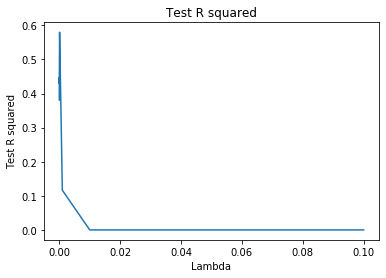

In [82]:
plt.plot(lambdas,accuracies)
plt.xlabel("Lambda")
plt.ylabel("Test R squared")
plt.title("Test R squared")

In [83]:
print("Best lambda is:",best_lambda )
print("Best test accuracy is:",best_accuracy )

Best lambda is: 0.0001
Best test accuracy is: 0.5798356024069486


**Comment:** Note how only small values of lambda produce a reasonable R squared score. Once the score reaches 1%, test score plummet. The penality is too high, and all coefficients become zero.

In [84]:
# prepare a dataframe with the coefficients
coef_pd = pd.DataFrame(np.transpose([best_lasso_model.coef_]),
            columns = ["best_lasso_model_coeff"], index=X_train.columns)

In [85]:
print("The number of NON-zero coefficients:", coef_pd[:][coef_pd['best_lasso_model_coeff']!=0].shape[0])
print("The number of zero coefficients:", coef_pd[:][coef_pd['best_lasso_model_coeff']==0].shape[0])

The number of NON-zero coefficients: 14
The number of zero coefficients: 119


In [86]:
# print all the non-zero coefficients
coef_pd[:][coef_pd['best_lasso_model_coeff']!=0]

,best_lasso_model_coeff
rate_w28_3,-0.384520
rate_w27_3,-0.074450
rate_w28_*_rate_w27,0.032169
rate_w28_*_dose1_w28,0.026036
rate_w28_*_bachelor,0.447401
rate_w28_*_inactivity,0.165413
rate_w28_*_obesity,0.243426
rate_w28_*_votergap20,-0.005096
rate_w27_*_dose1_w28,0.285941
rate_w27_*_unemployed,0.124788


**Comment:** Note how only 14 coefficients are non-zero, and none of them are non-polynomial versions of the main effects. This indicates the model believes there's limited linear relationship between the main predictors and the target. 

In [87]:
# w30 accuracy, based on train set as it is out of time and a larger sample
y_hat_train_w30 = covid_lasso.predict(X_train_w30) 
score_best_lasso_w30 = r2_score(y_train_w30, y_hat_train_w30)

In [88]:
# Add best tree to comparison table
model_comparison_df.loc['Poly, interact and lasso','test accuracy'] = best_accuracy
model_comparison_df.loc['Poly, interact and lasso','training accuracy'] = best_train_score
model_comparison_df.loc['Poly, interact and lasso','w30 accuracy'] = score_best_lasso_w30
# model_comparison_df.loc['Poly, interact and lasso','w30 accuracy'] = w30_accuracy

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,    
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%


**Comment:** The R squared on the w30 test set is negative. This indicates the model is overfit to the training data. We'll plot the out of time data below to confirm the intial data transformations were correct.

Text(0, 0.5, 'rate_w29')

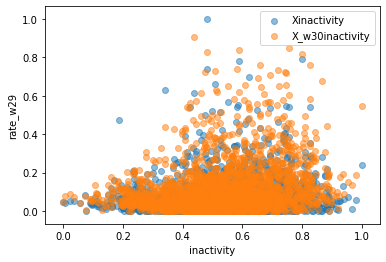

In [89]:
coef = 'inactivity'
plt.scatter(X_train[coef], y_train, label='X'+coef, alpha = 0.5)
plt.scatter(X_train_w30[coef], y_train_w30, label='X_w30'+coef, alpha = 0.5)
plt.legend()
plt.xlabel(coef)
plt.ylabel("rate_w29")

Text(0, 0.5, 'rate_w29')

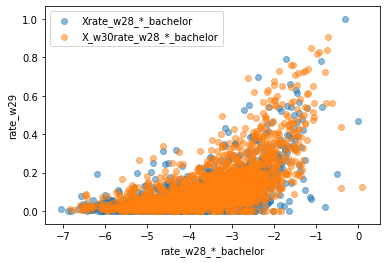

In [90]:
coef = 'rate_w28_*_bachelor'
plt.scatter(np.log(X_train[coef]), y_train, label='X'+coef, alpha = 0.5)
plt.scatter(np.log(X_train_w30[coef]), y_train_w30, label='X_w30'+coef, alpha = 0.5)
plt.legend()
plt.xlabel(coef)
plt.ylabel("rate_w29")

Text(0, 0.5, 'rate_w29')

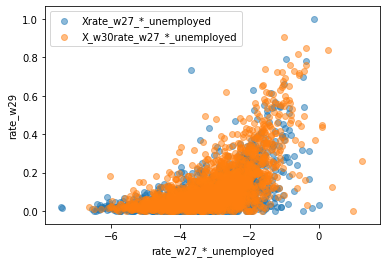

In [91]:
coef = 'rate_w27_*_unemployed'
plt.scatter(np.log(X_train[coef]), y_train, label='X'+coef, alpha = 0.5)
plt.scatter(np.log(X_train_w30[coef]), y_train_w30, label='X_w30'+coef, alpha = 0.5)
plt.legend()
plt.xlabel(coef)
plt.ylabel("rate_w29")

Text(0, 0.5, 'rate_w29')

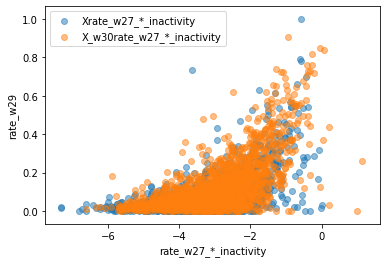

In [92]:
coef = 'rate_w27_*_inactivity'
plt.scatter(np.log(X_train[coef]), y_train, label='X'+coef, alpha = 0.5)
plt.scatter(np.log(X_train_w30[coef]), y_train_w30, label='X_w30'+coef, alpha = 0.5)
plt.legend()
plt.xlabel(coef)
plt.ylabel("rate_w29")

Text(0, 0.5, 'rate_w29')

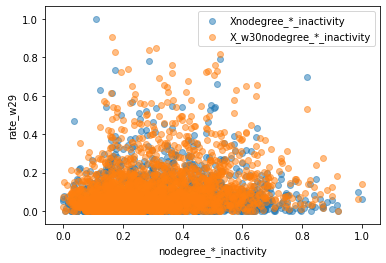

In [93]:
coef = 'nodegree_*_inactivity'
plt.scatter(X_train[coef], y_train, label='X'+coef, alpha = 0.5)
plt.scatter(X_train_w30[coef], y_train_w30, label='X_w30'+coef, alpha = 0.5)
plt.legend()
plt.xlabel(coef)
plt.ylabel("rate_w29")

**3.2** Plot the trajectory curves of the main effects `['rate_w28','rate_w27','fully_w28','votergap20']` from this model: the estimates of the $\beta$ coefficients as a function of $\lambda$.  Interpret what you notice.


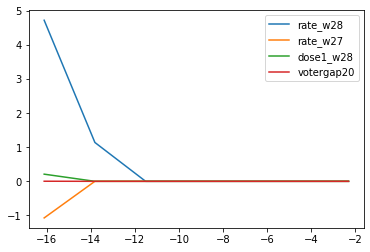

In [94]:
plt.plot(np.log(lambdas), rate_w28_coefs, label="rate_w28")
plt.plot(np.log(lambdas), rate_w27_coefs, label="rate_w27")
plt.plot(np.log(lambdas), dose1_w28_coefs, label="dose1_w28")
plt.plot(np.log(lambdas), votergap20_coefs, label="votergap20")
plt.legend()

**Comment:** Very small values of lambda add limited penalty to the coefficients. The smaller the value of lambda, the closer we get to OLS. For very small values of lambda, we can observe non-zero values for the coefficients. The coefficients are, however, zero for the best value for lambda.

**3.3** Fit a well-tuned random forest model to predict `rate_w29` from the predictors listed in 3.1.  Report your choice of the best tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.


In [95]:
# start random forest
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')
# downselecting columns
# not including 'cancer'
columns = ['rate_w28','rate_w27','dose1_w28','hispanic','minority','female','unemployed', 
            'income','nodegree','bachelor','inactivity','obesity','density','votergap20']
X = covid_clean.loc[:,columns]
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
# X_train = X_train.reindex()
# y_train = y_train.reindex()

# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [96]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [26,27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
#         print(next_feature, "in", curr_feature)
        covid_clean_w30[curr_feature] = covid_clean[next_feature].copy()

X_w30 = covid_clean_w30.loc[:,columns]
y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()

In [97]:
# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [98]:
random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [10,20,50,100]
depth_options = [5, 10, 15]
max_features_list = [2,5,10,len(X_train.columns)]
row_number = 0

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestRegressor(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            row_number = row_number + 1
            # retain the best scores
            if np.mean(R2s_test) > random_forest_test_score:
                random_forest_test_score = np.mean(R2s_test)
                random_forest_train_score = np.mean(R2s_train)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                best_RF_model = randomtree
                

In [99]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [100]:
# w30 accuracy
y_hat_train_w30 = best_RF_model.predict(X_train_w30) 
score_best_RF_w30 = r2_score(y_train_w30, y_hat_train_w30)

In [101]:
# Print out the best test scores
random_forest_comparison_df.sort_values('test accuracy', ascending=False).head()

,training accuracy,test accuracy
20 bagged trees w/ depth 10 and max_features 5,0.748361,0.689623
10 bagged trees w/ depth 5 and max_features 14,0.704023,0.656374
20 bagged trees w/ depth 5 and max_features 14,0.652217,0.649115
20 bagged trees w/ depth 15 and max_features 5,0.761738,0.643975
100 bagged trees w/ depth 15 and max_features 10,0.783067,0.6411


**Comment:** We're choosing the model with the best test accuracy:

In [102]:
print("The best tree number is:", best_tree_nr)
print("The best tree depth is:", best_depth)
print("The best max_features is:", best_max_features)

The best tree number is: 20
The best tree depth is: 10
The best max_features is: 5


In [103]:
# Add best tree to comparison table
model_comparison_df.loc['Random forest','training accuracy'] = random_forest_train_score
model_comparison_df.loc['Random forest','test accuracy'] = random_forest_test_score
model_comparison_df.loc['Random forest','w30 accuracy'] = score_best_RF_w30


# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%


**3.4** Interpret the relationship between `rate_w29` and `dose1_w28` from the random forest model in 3.3.  Is there any evidence of interactive effects in this model involving `dose1_w28`?  How do you know?  Provide a reasonable visual (or a few visuals) to help you with these tasks and interpret what you see. 



In [104]:
# Create the data frame of means to do the prediction
means1 = X_train.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

# Do the prediction at all observed dose1_w28
doses = np.arange(np.min(X_train['dose1_w28']),np.max(X_train['dose1_w28']))
means_df  = pd.concat([means_df]*doses.size,ignore_index=True)
means_df['dose1_w28'] = doses

In [105]:
means1.to_frame().transpose()

,rate_w28,rate_w27,dose1_w28,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,votergap20
0,0.000464,0.000342,33.28745,9.090958,15.154235,49.933473,5.496862,47.022739,15.083186,20.084071,26.004666,31.086806,249.27498,-31.350442


Text(0, 0.5, 'Rate_w29')

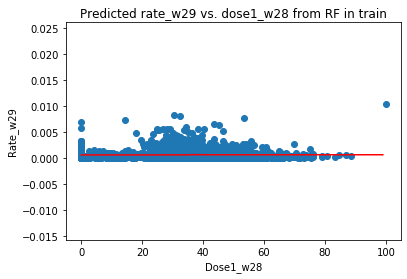

In [106]:
#plots at means
yhat_rf = best_RF_model.predict(means_df)
plt.scatter(X_train['dose1_w28'],y_train)
plt.plot(means_df['dose1_w28'],yhat_rf,color="red")
plt.title("Predicted rate_w29 vs. dose1_w28 from RF in train")
plt.xlabel("Dose1_w28")
plt.ylabel("Rate_w29")

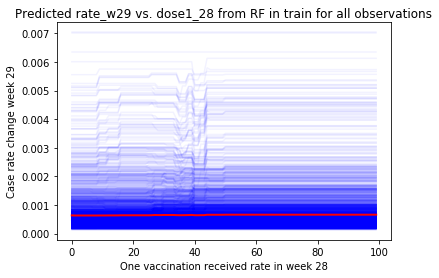

In [107]:
#Plots for all observations.  And then averaged
yhat_rfs = []
for i in range(0,X_train.shape[0]):
    obs = X_train.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*doses.size,ignore_index=True)
    obs_df['dose1_w28'] = doses
    yhat_rf = best_RF_model.predict(obs_df)
    yhat_rfs.append(yhat_rf)
    plt.plot(obs_df['dose1_w28'],yhat_rf,color='blue',alpha=0.05)

plt.plot(obs_df['dose1_w28'],np.mean(yhat_rfs, axis=0),color='red',linewidth=2);
    
# plt.ylim(0,1)
plt.xlabel("One vaccination received rate in week 28")
plt.ylabel("Case rate change week 29")
plt.title("Predicted rate_w29 vs. dose1_28 from RF in train for all observations");

**Comment:** We can observe that in the randomforest model dose1_w28 does not have much of an effect on predicted values: the red (average) line is flat. We also plotted the full range of dose1_w28 for each observation in the training set. We can observe that the graph shape for dose1_w28 varies only marginally between the observations. We can therefore conclude that limited interaction effects exist between dose1_w28 and other predictors.

**3.5** Fit a well-tuned boosting model to predict `rate_w29` from the predictors listed in 3.1.  Report your best choice of the tuning parameters and briefly justify your choice (a visual or table may be helpful for this).  Provide an estimate of out-of-sample $R^2$.  Note: again, do not go to crazy with the number of options for the parameters you are tuning...choose a set of values that are reasonable.



In [108]:
boosts = []
boostfts = []
depths = [1, 2, 3, 4,5,6,7]
# build boost models with base estimators of different depths
for base_depth in depths:
    boost = AdaBoostRegressor( base_estimator = DecisionTreeRegressor(max_depth = base_depth),
                              n_estimators=100)
    boosts.append(boost)


    # Fit on the entire data
    boostfit = boost.fit(X_train,y_train)
    boostfts.append(boostfit)

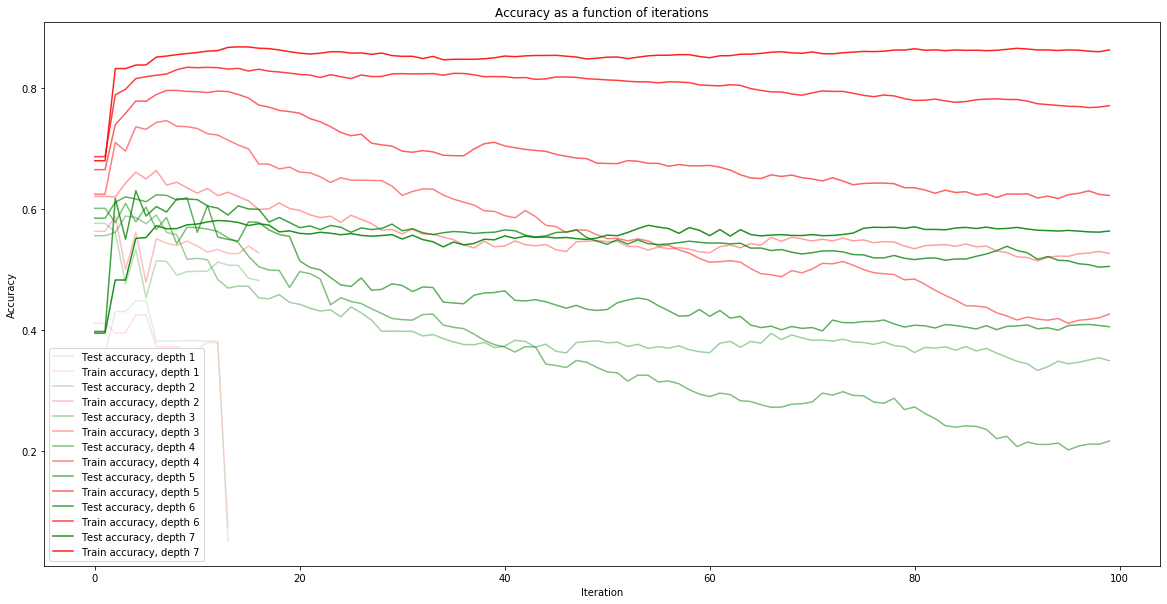

In [109]:
# plot accuracy by estimator for different base depths
plt.rcParams["figure.figsize"] = (20,10)
for base_depth in depths:
    plt.plot(list(boosts[base_depth -1].staged_score(X_test,y_test)),
             label="Test accuracy, depth " + str(base_depth), color = "green", alpha = base_depth/8)
    plt.plot(list(boosts[base_depth -1].staged_score(X_train,y_train)),
             label="Train accuracy, depth " + str(base_depth), color = "red", alpha = base_depth/8)
    plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of iterations")
plt.legend()

In [110]:
# we've visually assessed initial depth equal to three to be the best option
best_depth = 3
best_boost = boosts[best_depth -1]
train_list = list(best_boost.staged_score(X_train,y_train))
test_list = list(best_boost.staged_score(X_test,y_test))

# assess which iteration is best
index_best_accuracy = test_list.index(max(test_list))
print("The iteration with the best accuracy is:", index_best_accuracy)

The iteration with the best accuracy is: 6


In [111]:
# w30 accuracy
w30_list = list(best_boost.staged_score(X_train_w30,y_train_w30))

In [112]:
# Add best tree to comparison table
model_comparison_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','w30 accuracy'] = w30_list[index_best_accuracy]

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%
Adaboost,66.4%,59.0%,65.5%


**Comment:** The best adaboost model seems to be a smiple one with initial depth equal to three. As we increase the initial depth more, the model becomes overfit: test scores do not improve, but train scores do. We also note that the best model has very few iterations. This indicates we lack important variables: with the data availalble, the model cannot improve.

In [113]:
# Add best tree to comparison table
model_comparison_df.loc['Adaboost','training accuracy'] = train_list[index_best_accuracy]
model_comparison_df.loc['Adaboost','test accuracy'] = test_list[index_best_accuracy]

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
    'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%
Adaboost,66.4%,59.0%,65.5%


**3.6** Improve upon your favorite/best predictive model from 3.1, 3.3, or 3.5, by including other provided feature, by doing feature engineering, or by doing variable removal/selection.  Explain your choices.  Provide an estimate of out-of-sample $R^2$. 



**Comment:** We'll proceed with the random forest as it is the simplest model to manage interactions.This is particularly useful to deal with the out of time test dataset.
We're adding all features to the dataset. We'll, in particular, add features associated with patterns we notice before: (one hot encoded) states. 

In [114]:
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')

In [115]:
# notice we didn't exclude states
covid_clean = covid_clean.drop(['date','county', 'fips'],axis=1) 

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean.shape[0]
covid_clean = covid_clean.loc[:,:][covid_clean['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean.shape[0])

#convert votergap16 to dtype float
covid_clean['votergap16'] = covid_clean['votergap16'].astype(float)

Number of rows removed by cleaning up non-numeric values: 2


In [116]:
# one hot encoding states
enc = OneHotEncoder(handle_unknown='ignore')
enc_fit = enc.fit_transform(covid_clean[['state']])

# capturing the state names
column_names = enc.get_feature_names(['state'])
enc_df = pd.DataFrame(enc_fit.todense(), columns=column_names)

# merge with main df bridge_df on key values
covid_clean = covid_clean.join(enc_df)
covid_clean = covid_clean.drop(['state'], axis=1)


In [117]:
# dropping a couple of NaN states 
covid_clean = covid_clean.dropna()

In [118]:
# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
        # plug the value of the previous week into the current week
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
# drop w29 as that's now plugged into w28
X_w30 = covid_clean_w30.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
# Drop future data
X_w30 = X_w30.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30', 'rate_w29'],axis=1)
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()


In [119]:
# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

In [120]:
# split predictor and target dataset
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
X = covid_clean.drop(['rate_w29'], axis=1)

In [121]:
# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
X = X.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
X = X.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)

In [122]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [123]:
# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

In [124]:
random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [10,20,50,100]
depth_options = [5, 10, 15]
# max_features_list = [2,5,10,len(X_train.columns)]
max_features_list = [2,len(X_train.columns)]

row_number = 0

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []            
            R2s_w30 = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestRegressor(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            R2s_w30 = np.append(R2s_w30,randomtree.score(X_test_w30, y_test_w30))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            row_number = row_number + 1
            # retain the best scores
            if np.mean(R2s_test) > random_forest_test_score:
                random_forest_train_score = np.mean(R2s_train)
                random_forest_test_score = np.mean(R2s_test)
                random_forest_w30_test_score = np.mean(R2s_w30)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                best_RF_all_Feature_model = randomtree
                
                
# Print out the best test scores
random_forest_comparison_df.sort_values('test accuracy', ascending=False).head()

,training accuracy,test accuracy
100 bagged trees w/ depth 15 and max_features 82,0.79659,0.681875
20 bagged trees w/ depth 15 and max_features 82,0.769443,0.658846
10 bagged trees w/ depth 15 and max_features 82,0.713635,0.656698
20 bagged trees w/ depth 5 and max_features 82,0.721316,0.651202
20 bagged trees w/ depth 10 and max_features 82,0.76196,0.647339


In [125]:
# Add best tree to comparison table
model_comparison_df.loc['RF all features','training accuracy'] = random_forest_train_score
model_comparison_df.loc['RF all features','test accuracy'] = random_forest_test_score
model_comparison_df.loc['RF all features','w30 accuracy'] = random_forest_w30_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%
Adaboost,66.4%,59.0%,65.5%
RF all features,79.7%,68.2%,69.8%


In [126]:
import eli5
#permutation importance for the random forest
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(best_RF_all_Feature_model,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())

Weight,Feature
0.8363 ± 0.1176,rate_w28
0.1129 ± 0.0361,rate_w27
0.0257 ± 0.0446,state_Illinois
0.0242 ± 0.0161,state_Missouri
0.0211 ± 0.0363,density
0.0118 ± 0.0096,hispanic
0.0095 ± 0.0117,never
0.0090 ± 0.0056,fully_w28
0.0086 ± 0.0083,bachelor
0.0072 ± 0.0147,fully_w26


**Comment:** The important feature look reasonable. Some fascinating features pop up. Fully vaccinated pops up as a predictor for case rate changes in week_29. This makes intuitive sense as vaccinations take a while to take effect. Note also that certain states have popped up. Adding features (and states in particular) improved results. For some samples, the difference between R squared for train and the test set is higher than for others. However, test and out of time results are consistent.

**3.7** Evaluate your models from 3.1, 3.3, 3.5, and 3.6 on the test set (this will take some work...refer back to 2.8) using $R^2$.  How do these model's $R^2$ in test compare to the out-of-sample $R^2$ when tuning?  Explain whether this is surprising or not?

In [127]:
# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%
Adaboost,66.4%,59.0%,65.5%
RF all features,79.7%,68.2%,69.8%


**Comment:** We expect the models to perform significantly worse on the test set. Discussion by model:
- The Lasso model (with polynomials and feature interactions) does not perform on the test set at all. As R squared is negative, it performs worse than drawing a straight line at the mean of rate_w30. This indicates the model was too overfit to the training and validation data. In doing so, too many coefficients were reduced to 0.
- Random forest and Adaboost perform as expected: results on out of time data is in line with accurary on the test set.
- The random forest model with more features (including state) improves out of time results.

Note: references to "out of time" refer to w30 results.

---

## Question 4 [10pts]: Going further

**4.1** Use all of the useable variables in `demo` and `masks` to create clusters of observations based on the $K$-means clustering approach.  Be sure to carefully select a reasonable choice for $K$.  Explain your choice (a visual may help with this).

**4.2** Use your created clusters and incorporate them as predictor(s) into a linear regression model to assess whether the relationships you measured in the model from 2.6 depend on cluster type.  Comment on what you notice.  Determine whether out-of-sample $R^2$ has improved using this model (in comparison to the model from 2.6) based on 5-fold CV.

**4.3: BONUS** Find data online to improve the prediction accuracy of your best model. Be sure to cite your source of your data and the approach you took into incorporating these new data.  Note: this is only worth up to 3 bonus points, so do not spend too much effor on this part over improving ealrier parts of the exam.

## Answers

**4.1** Use all of the useable variables in `demo` and `masks` to create clusters of observations based on the $K$-means clustering approach.  Be sure to carefully select a reasonable choice for $K$.  Explain your choice (a visual may help with this).

In [128]:
# read the cleaned dataset
covid_clean = pd.read_csv('data/covid_clean.csv')

In [129]:
# prepare the data to use all possible "raw" predictors
# removing all the non-numeric columns
covid_clean_num_only = covid_clean.drop(['date','county', 'state'],axis=1) 
# covid_clean_num_only = covid_clean.copy()

# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
covid_clean_num_only = covid_clean_num_only.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
covid_clean_num_only = covid_clean_num_only.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean_num_only.shape[0]
covid_clean_num_only = covid_clean_num_only.loc[:,:][covid_clean_num_only['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean_num_only.shape[0])

#convert votergap16 to dtype float
covid_clean_num_only['votergap16'] = covid_clean_num_only['votergap16'].astype(float)

#standardize the features
column_names = covid_clean_num_only.columns
scale_transformer = MinMaxScaler(copy=True).fit(covid_clean_num_only)
covid_clean_num_only = pd.DataFrame(scale_transformer.transform(covid_clean_num_only))
covid_clean_num_only.columns = column_names

Number of rows removed by cleaning up non-numeric values: 2


In [130]:
masks_demo = covid_clean[['never', 'rarely', 'never', 'sometimes', 'frequently', 'always', 
                         'population', 'hispanic', 'minority', 'female', 'unemployed',
                         'income', 'nodegree', 'bachelor', 'inactivity', 'obesity',
                         'density','votergap20', 'votergap16'
                        ]].copy()

In [131]:
orig_nr_rows = masks_demo.shape[0]
masks_demo = masks_demo.loc[:,:][masks_demo['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - masks_demo.shape[0])

#convert votergap16 to dtype float
masks_demo['votergap16'] = masks_demo['votergap16'].astype(float)

Number of rows removed by cleaning up non-numeric values: 2


In [132]:
#standardize the features
column_names = masks_demo.columns
scale_transformer = MinMaxScaler(copy=True).fit(masks_demo)
masks_demo = pd.DataFrame(scale_transformer.transform(masks_demo))
masks_demo.columns = column_names

In [133]:
assert masks_demo.shape[0] == covid_clean_num_only.shape[0]

In [134]:
# cluster the data
X = masks_demo
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

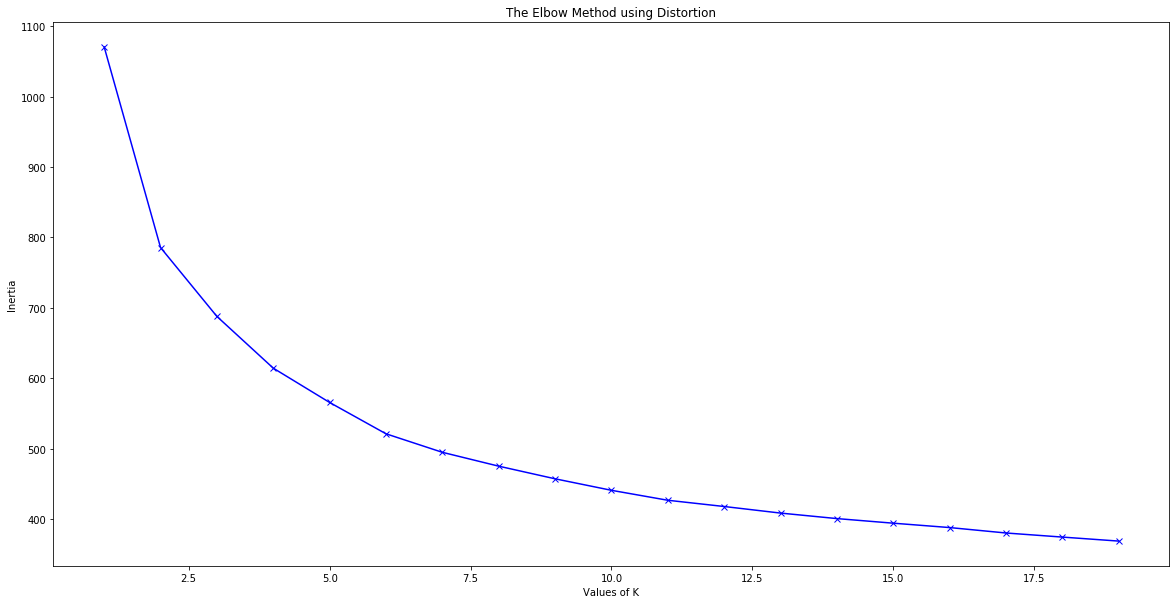

In [135]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Distortion')
plt.show()

**Comment:** Based on the elbow chart, we'd recommend choosing 6 clusters. That's the point where adding more clusters starts having marginal improvement only.

In [136]:
n_clust = 6
kmeansN = KMeans(n_clusters=n_clust, random_state=109).fit(X)

# sum of squares from the centroids
print("Sum of Squared Distances =", kmeansN.inertia_)

kmeansn_predictions = kmeansN.predict(X)
#predict for new (or current) observations
print("Predicted clusters for each observation =", kmeansN.predict(X))

Sum of Squared Distances = 520.9452314326617
Predicted clusters for each observation = [3 1 2 ... 0 0 0]


**4.2** Use your created clusters and incorporate them as predictor(s) into a linear regression model to assess whether the relationships you measured in the model from 2.6 depend on cluster type.  Comment on what you notice.  Determine whether out-of-sample $R^2$ has improved using this model (in comparison to the model from 2.6) based on 5-fold CV.


In [137]:
covid_clean_num_only_w_clusters = covid_clean_num_only.copy()
covid_clean_num_only_w_clusters['kmeans_cluster'] = kmeansn_predictions.tolist()

In [138]:
# manage the target variable
X = covid_clean_num_only_w_clusters.loc[:, covid_clean_num_only_w_clusters.columns != 'rate_w29']
y = covid_clean_num_only_w_clusters.rate_w29

In [139]:
# one hot encode the clusters as cluster numbers by themselves have no meaning
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
kmeans_cols = ['Clust0', 'Clust1', 'Clust2', 'Clust3', 'Clust4', 'Clust5', ]
enc_df = pd.DataFrame(enc.fit_transform(X[['kmeans_cluster']]).toarray())
enc_df.columns = kmeans_cols
# merge with main df bridge_df on key values
X = X.join(enc_df)
X = X.drop(['kmeans_cluster'], axis=1)
# enc_df

In [140]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [141]:
# train using statsmodel to inspect the coefficiencts and p-values
OLS_x_train = sm.tools.add_constant(X_train)
OLS_x_test = sm.tools.add_constant(X_test)

OLSModel = OLS(y_train,OLS_x_train).fit()

# train accuracy
y_hat_train_pred_42 = OLSModel.predict(OLS_x_train) 
train_score_42 = r2_score(y_train, y_hat_train_pred_42)

# test_accuracy
y_hat_test_pred_42 = OLSModel.predict(OLS_x_test) 
test_score_42 = r2_score(y_test.to_numpy(), y_hat_test_pred_42)

print("OLS model train accuracy: ", train_score_42)
print("OLS model test accuracy: ", test_score_42)

OLSModel.summary()

OLS model train accuracy:  0.558648532873514
OLS model test accuracy:  0.49607248111232305


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rate_w29   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     81.44
Date:                Wed, 04 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:29:14   Log-Likelihood:                 3477.8
No. Observations:                2484   AIC:                            -6878.
Df Residuals:                    2445   BIC:                            -6651.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8372      1.373      0.610      0.542      -1.856       3.530
fips          -0.0413      0.005     -8.698      0.000      -0.051      -0.032
cases_w26     85.9012     34.791      2.469      0.014      17.679     154.123
deaths_w26   -10.3387     12.472     -0.829      0.407     -34.796      14.119
fully_w26     -1.1404      0.449     -2.543      0.011      -2.020      -0.261
dose1_w26      0.0734      0.053      1.388      0.165      -0.030       0.177
cases_w27   -293.0996     61.729     -4.748      0.000    -414.146    -172.053
deaths_w27    14.2390     23.962      0.594      0.552     -32.749      61.227
fully_w27      1.5907      0.799      1.991      0.047       0.024       3.157
dose1_w27     -0.0110      0.080     -0.137      0.891      -0.168       0.146
cases_w28    207.3650     29.896      6.936      0.000     148.741     265.989
deaths_w28    -3.9165     15.424     -0.254      0.800     -34.162      26.329
fully_w28     -0.5233      0.607     -0.862      0.389      -1.714       0.668
dose1_w28     -0.0027      0.070     -0.039      0.969      -0.140       0.135
population     0.0227      0.225      0.101      0.920      -0.418       0.464
hispanic       0.0025      0.018      0.141      0.888      -0.032       0.037
minority       0.0189      0.014      1.311      0.190      -0.009       0.047
female        -0.0355      0.016     -2.192      0.028      -0.067      -0.004
unemployed     0.0051      0.020      0.250      0.802      -0.035       0.045
income        -0.0518      0.017     -3.041      0.002      -0.085      -0.018
nodegree       0.0309      0.019      1.644      0.100      -0.006       0.068
bachelor       0.1438      0.021      6.710      0.000       0.102       0.186
inactivity     0.0535      0.015      3.550      0.000       0.024       0.083
obesity        0.0382      0.016      2.347      0.019       0.006       0.070
density       -0.0205      0.045     -0.456      0.648      -0.108       0.067
votergap20    -0.1416      0.054     -2.610      0.009      -0.248      -0.035
votergap16     0.0895      0.051      1.750      0.080      -0.011       0.190
never         -0.4719      0.809     -0.583      0.560      -2.059       1.115
rarely        -0.4384      0.720     -0.609      0.543      -1.850       0.973
sometimes     -0.4671      0.789     -0.592      0.554      -2.013       1.079
frequently    -0.6238      0.974     -0.640      0.522      -2.534       1.287
always        -0.8577      1.450     -0.592      0.554      -3.701       1.986
rate_w28       0.7444      0.037     20.113      0.000       0.672       0.817
rate_w27       0.4626      0.020     23.360      0.000       0.424       0.501
Clust0         0.1420      0.229      0.620      0.535      -0.307       0.591
Clust1         0.1466      0.229      0.640      0.522      -0.302       0.596
Cl

**Comment:** Based on the p-value for the one hot encoded clusterings, no improvement came from clustering. The R-squared for train and test haven't changed. Clustering did not improve the result.

In [142]:
# using scikitlearn for 5-fold cross validation
lm = LinearRegression().fit(X_train, y_train)
w30_scores = cross_val_score(lm, X_train_w30, y_train_w30, cv=5)

print("R-sq Train=",lm.score(X_train, y_train))
print("R-sq Train=",lm.score(X_test, y_test))
print("R-sq w30 train=",np.mean(w30_scores))

R-sq Train= 0.558648532873514
R-sq Train= 0.4960724811121658
R-sq w30 train= 0.7305686112128137


**Comment:** The out of time test scores with cross validation, however, performs well at 73%

*your answer here*

**4.3: BONUS** Find data online to improve the prediction accuracy of your best model. Be sure to cite your source of your data and the approach you took into incorporating these new data.  Note: this is only worth up to 3 bonus points, so do not spend too much effor on this part over improving ealrier parts of the exam.

In [181]:
# source: https://github.com/ykzeng/covid-19/tree/master/data
census_extra = pd.read_csv('data/census-landarea-all.csv')

In [182]:
census_extra.head()

,fips,PST045212,PST040210,PST120212,POP010210,AGE135212,AGE295212,AGE775212,SEX255212,RHI125212,RHI225212,RHI325212,RHI425212,RHI525212,RHI625212,RHI725212,RHI825212,POP715211,POP645211,POP815211,EDU635211,EDU685211,VET605211,LFE305211,HSG010211,HSG445211,HSG096211,HSG495211,HSD410211,HSD310211,INC910211,INC110211,PVY020211,BZA010211,BZA110211,BZA115211,NES010211,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030212,LND110210,POP060210
0,0,313914040,308747508,1.7,308745538,6.4,23.5,13.7,50.8,77.9,13.1,1.2,5.1,0.2,2.4,16.9,63.0,84.6,12.8,20.3,85.4,28.2,22215303,25.4,132312404,66.1,25.9,186200,114761359,2.60,27915,52762,14.3,7354043,113425965,1.3,22491080,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,829658,3531905.43,87.4
1,1000,4822023,4779745,0.9,4779736,6.3,23.3,14.5,51.5,70.0,26.5,0.7,1.2,0.1,1.5,4.1,66.6,84.5,3.4,5.0,81.9,22.0,403982,24.0,2182088,70.7,15.5,120800,1831269,2.53,23483,42934,17.6,97743,1573138,0.3,321641,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13506,50645.33,94.4
2,1001,55514,54571,1.7,54571,6.5,26.0,13.0,51.3,78.5,18.4,0.5,1.0,0.1,1.5,2.6,76.4,84.8,2.0,3.8,86.5,21.6,5942,25.3,22460,77.7,7.2,137500,19998,2.68,25035,53899,10.9,835,10290,1.2,3062,4067,15.2,0.0,1.3,0.0,0.7,31.7,0,0,598175,12003,88157,385,594.44,91.8
3,1003,190790,182265,4.7,182265,5.9,22.6,17.7,51.2,87.3,9.6,0.7,0.8,0.1,1.5,4.6,83.2,83.3,3.7,5.4,87.9,27.2,20254,25.5,104701,76.2,23.3,175700,70757,2.50,27217,51321,12.5,4624,51386,0.4,16097,19035,2.7,0.4,1.0,0.0,1.3,27.3,1410273,0,2966489,17166,436955,1184,1589.78,114.6
4,1005,27201,27457,-0.9,27457,5.6,21.2,15.2,46.3,50.5,47.4,0.7,0.4,0.2,0.8,5.1,46.4,82.1,3.0,5.0,72.4,13.9,2167,23.4,11692,66.4,10.3,91600,9589,2.57,15899,34041,24.7,501,7572,-0.4,1513,1667,0.0,0.0,0.0,0.0,0.0,27.0,0,0,188337,6334,0,2,884.88,31.0


In [183]:
census_extra[['fips','AGE775212']].head()

,fips,AGE775212
0,0,13.7
1,1000,14.5
2,1001,13.0
3,1003,17.7
4,1005,15.2


In [184]:
census_extra_65 = census_extra[['fips','AGE775212']]

In [185]:
# restart from clean data
covid_clean = pd.read_csv('data/covid_clean.csv')

In [186]:
# merge based on FIPS
covid_clean = covid_clean.merge(census_extra_65, on=['fips'])

In [187]:
covid_clean['dens*65'] = covid_clean['AGE775212']* covid_clean['AGE775212']

In [188]:
# notice we didn't exclude states
covid_clean = covid_clean.drop(['date','county', 'fips'],axis=1) 

# cleaning out a couple of records with non-numeric values in votergap16
orig_nr_rows = covid_clean.shape[0]
covid_clean = covid_clean.loc[:,:][covid_clean['votergap16']!='#VALUE!']
print("Number of rows removed by cleaning up non-numeric values:", orig_nr_rows - covid_clean.shape[0])

#convert votergap16 to dtype float
covid_clean['votergap16'] = covid_clean['votergap16'].astype(float)

# one hot encoding states
enc = OneHotEncoder(handle_unknown='ignore')
enc_fit = enc.fit_transform(covid_clean[['state']])

# capturing the state names
column_names = enc.get_feature_names(['state'])
enc_df = pd.DataFrame(enc_fit.todense(), columns=column_names)

# merge with main df bridge_df on key values
covid_clean = covid_clean.join(enc_df)
covid_clean = covid_clean.drop(['state'], axis=1)

# dropping a couple of NaN states 
covid_clean = covid_clean.dropna()

# prepare out of time data
covid_clean_w30 = covid_clean.copy()
latest_week = 29
features = []
weeks = [27,28]
week_dependent_features = ['cases','deaths', 'fully', 'dose1', 'rate']

for week in weeks:
    for column in week_dependent_features:
        curr_feature = column + '_w' + str(week)
        next_feature = column + '_w' + str(week + 1)
        features.append(curr_feature)
        # plug the value of the previous week into the current week
        covid_clean_w30[curr_feature] = covid_clean_w30[next_feature]

y_w30 = pd.DataFrame(covid_clean_w30.loc[:,['rate_w30']])
# drop w29 as that's now plugged into w28
X_w30 = covid_clean_w30.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
# Drop future data
X_w30 = X_w30.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30', 'rate_w29'],axis=1)
X_w30 = X_w30.reindex()
y_w30 = y_w30.reindex()

# w30 data prep
# split dataset in train and test
X_train_w30, X_test_w30, y_train_w30, y_test_w30 = train_test_split(X_w30, y_w30, test_size=0.2, random_state = 109)

# split predictor and target dataset
y = pd.DataFrame(covid_clean.loc[:,['rate_w29']])
X = covid_clean.drop(['rate_w29'], axis=1)


# removing the data from week 29 and week 30 as this wouldn't be known at prediction time
X = X.drop(['cases_w29','deaths_w29', 'fully_w29', 'dose1_w29'],axis=1)
X = X.drop(['cases_w30','deaths_w30', 'fully_w30', 'dose1_w30', 'rate_w30'],axis=1)

# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# prepare a dataframe to represent rates for each model
random_forest_comparison_df = pd.DataFrame(
    columns=['training accuracy', 'test accuracy']
)

random_forest_train_score = -1
random_forest_test_score = -1
depth_option = 7
tree_nr_options = [10,20,50,100]
depth_options = [5, 10, 15]
# max_features_list = [2,5,10,len(X_train.columns)]
max_features_list = [2,len(X_train.columns)]

row_number = 0

# go through all the depth options we want to explore
for depth_option in depth_options:
    # go through all the options for nr of trees we want to explore
    for ntrees in tree_nr_options:
        # buld ntrees trees
        for max_features in max_features_list:
            estimators = []
            R2s_train = []
            R2s_test = []            
            R2s_w30 = []
            y_hats_test = np.zeros((X_test.shape[0], ntrees))
            randomtree = RandomForestRegressor(max_depth=depth_option, max_features = max_features)
            # bootstap the training set
            boot_x, boot_y = resample(X_train, y_train)
            
            # fit and test the model
            estimators = np.append(estimators,randomtree.fit(boot_x, boot_y))
            R2s_train = np.append(R2s_train,randomtree.score(X_train, y_train))
            R2s_test = np.append(R2s_test,randomtree.score(X_test, y_test))
            R2s_w30 = np.append(R2s_w30,randomtree.score(X_test_w30, y_test_w30))
            
            # Add rates to dataframe for clear comparison 
            curr_tree_descr = str(ntrees) + ' bagged trees w/ depth ' + str(depth_option) + " and max_features " + str(max_features)
            random_forest_comparison_df.loc[curr_tree_descr,'training accuracy'] = np.mean(R2s_train)
            
            # accuracy scores on test set
            random_forest_comparison_df.loc[curr_tree_descr,'test accuracy'] = np.mean(R2s_test)
            
            row_number = row_number + 1
            # retain the best scores
            if np.mean(R2s_test) > random_forest_test_score:
                random_forest_train_score = np.mean(R2s_train)
                random_forest_test_score = np.mean(R2s_test)
                random_forest_w30_test_score = np.mean(R2s_w30)
                best_tree_nr = ntrees
                best_depth = depth_option
                best_max_features = max_features
                best_RF_all_Feature_model = randomtree
                
                
# Print out the best test scores
random_forest_comparison_df.sort_values('test accuracy', ascending=False).head()

Number of rows removed by cleaning up non-numeric values: 2


,training accuracy,test accuracy
20 bagged trees w/ depth 5 and max_features 84,0.703707,0.661138
100 bagged trees w/ depth 10 and max_features 84,0.794602,0.651803
100 bagged trees w/ depth 5 and max_features 84,0.743006,0.630372
20 bagged trees w/ depth 15 and max_features 84,0.802819,0.612398
10 bagged trees w/ depth 10 and max_features 84,0.780709,0.610207


In [189]:
# Add best tree to comparison table
model_comparison_df.loc['RF all features_w_over_65','training accuracy'] = random_forest_train_score
model_comparison_df.loc['RF all features_w_over_65','test accuracy'] = random_forest_test_score
model_comparison_df.loc['RF all features_w_over_65','w30 accuracy'] = random_forest_w30_test_score

# display the rates by model in percentage format
model_comparison_df.style.format({
    'training accuracy': '{:,.1%}'.format,
    'test accuracy': '{:,.1%}'.format,
        'w30 accuracy': '{:,.1%}'.format,
})

,training accuracy,test accuracy,w30 accuracy
OLS_from2.6,57.5%,49.7%,nan%
"Poly, interact and lasso",59.1%,58.0%,-10.5%
Random forest,74.8%,69.0%,67.1%
Adaboost,66.4%,59.0%,65.5%
RF all features,79.7%,68.2%,69.8%
RF all features_w_over_65,70.4%,66.1%,65.0%


In [190]:
import eli5
#permutation importance for the random forest
from eli5.sklearn import PermutationImportance

seed = 42

perm = PermutationImportance(best_RF_all_Feature_model,random_state=seed,n_iter=10).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X.columns.tolist())

Weight,Feature
0.8894 ± 0.0836,rate_w28
0.1647 ± 0.0328,rate_w27
0.0138 ± 0.0136,minority
0.0082 ± 0.0110,population
0.0071 ± 0.0045,nodegree
0.0066 ± 0.0011,state_Missouri
0.0036 ± 0.0051,deaths_w28
0.0030 ± 0.0035,bachelor
0.0028 ± 0.0049,rarely
0.0024 ± 0.0017,deaths_w27


**Comment:** We added percentage of folks over 65. 